In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
#!pip install pandas
#!pip install tqdm

#!pip install scipy
#!pip install matchms
#!pip install scikit-learn
#!pip install spec2vec
#!pip install seaborn

In [4]:
import os
os.chdir('/Users/sebas/projects/metabolomics')
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

In [5]:
from src.transformers.sklearn_model import SklearnModel

Seed set to 42


In [28]:
import gensim
from src.load_data import LoadData
from src.config import Config
from matchms import calculate_scores
from matchms.importing import load_from_mgf,load_from_msp
import matchms.filtering as msfilters
from spec2vec import SpectrumDocument
from spec2vec.model_building import train_new_word2vec_model
from tqdm import tqdm
from src.loader_saver import LoaderSaver
import itertools
from pytorch_lightning.callbacks import ProgressBar
from src.losscallback import LossCallback
import numpy as np
from matchms.importing import load_from_msp
from matchms.similarity import ModifiedCosine
from scipy.stats import spearmanr
import dill
from src.plotting import Plotting
from torch.utils.data import DataLoader, WeightedRandomSampler
import lightning.pytorch as pl
from src.load_data import LoadData
from sklearn.model_selection import train_test_split
from src.train_utils import TrainUtils
from src.preprocessor import Preprocessor
from matchms.filtering import add_fingerprint
import pickle
import sys
from src.config import Config
from src.parser import Parser
from datetime import datetime
from src.weight_sampling import WeightSampling
from src.loader_saver import LoaderSaver
from src.spec2vec_comparison import Spec2VecComparison
from src.ms2deepscore_comparison import MS2DeepScoreComparison
from src.molecular_pairs_set import MolecularPairsSet
from scipy.stats import spearmanr
from src.transformers.load_data import LoadData as LoadDataTrans

In [7]:
from src.transformers.embedder import Embedder

In [8]:
ls /Users/sebas/projects/data

ALL_GNPS_NO_PROPOGATED_wb.mgf
GNPS-NIH-NATURALPRODUCTSLIBRARY.mgf
all_spectrums_gnps.pkl
all_spectrums_gnps_nist_20240130_gnps_nist_janssen.pkl
all_spectrums_janssen.pkl
all_spectrums_nist.pkl
best_model.ckpt
best_model_128n_10_layers_20240209.ckpt
best_model_128n_5_layers_20240219_elementwise.ckpt
best_model_128n_5_layers_20240229.ckpt
best_model_128n_5_layers_20240303.ckpt
best_model_20240301.ckpt
drug_plus.mgf
hr_msms_nist_all.MSP*
hr_msms_nist_sample.MSP
merged_gnps_nist_20240118_gnps_nist_janssen.pkl
merged_gnps_nist_20240207_gnps_nist_janssen_15_millions.pkl
merged_gnps_nist_20240227_gnps_nist_janssen_20_millions_OUTSIDE_MAX_DIFF_NO_JANSSEN.pkl
ms2deepscore_positive_10k_1000_1000_1000_500.hdf5
spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model
spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model.trainables.syn1neg.npy
spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model.wv.vectors.npy
to_export_gnps_nist.pkl
uniformed_molecule_pairs_test.pkl


## Parameters

In [9]:
data_folder= '/Users/sebas/projects/data/'
dataset_path = data_folder + 'uniformed_molecule_pairs_test.pkl'
gnps_path =  data_folder + 'ALL_GNPS_NO_PROPOGATED_wb.mgf'
janssen_path = data_folder + 'drug_plus.mgf'
nist_path = data_folder + 'hr_msms_nist_all.MSP'
output_pairs_file= data_folder + 'molecular_pairs.pkl'
output_nist_file= data_folder + 'all_spectrums_nist.pkl'
output_gnps_file= data_folder + 'all_spectrums_gnps.pkl'
output_janssen_file= data_folder + 'all_spectrums_janssen.pkl'
model_spec2vec_file = data_folder + 'spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model'
model_ms2d_file= data_folder + 'ms2deepscore_positive_10k_1000_1000_1000_500.hdf5'
#uniformed_molecule_pairs_test_path= data_folder +'uniformed_molecule_pairs_test.pkl'
uniformed_molecule_pairs_test_path= data_folder +'merged_gnps_nist_20240207_gnps_nist_janssen_15_millions.pkl'
transformer_path = data_folder + 'best_model_128n_5_layers_20240219_elementwise.ckpt'

In [10]:
THRESHOLD_ANALOG=0.7

In [11]:
load_molecule_pairs_file= True
only_use_gnps=False

In [12]:
## Load spectrum using spectrumutils

In [13]:
config=Config()

In [14]:
ls -lh notebooks/pretraining/results

total 201056
-rw-r--r--  1 sebas  staff    20M Feb 28 14:34 best_model-v1.ckpt
-rw-r--r--  1 sebas  staff    20M Feb 28 16:25 best_model-v2.ckpt
-rw-r--r--  1 sebas  staff    19M Mar  5 11:10 best_model-v3.ckpt
-rw-r--r--  1 sebas  staff    20M Feb 28 11:51 best_model.ckpt
-rw-r--r--  1 sebas  staff    20M Feb 28 11:41 best_model_20240228.ckpt
-rw-r--r--  1 sebas  staff    54K Mar  5 11:10 loss.png


In [15]:
config.CHECKPOINT_DIR = './notebooks/pretraining/results_after_training'

In [16]:

pretrained_path = './notebooks/pretraining/results/best_model-v3.ckpt'

In [17]:
folder_results_no_pretraining= './notebooks/pretraining/results_training_no_maldi'
folder_results_with_pretraining= './notebooks/pretraining/results_training_maldi'

In [18]:
NUMBER_TRAIN_PAIRS=1000

## Load molecular pairs

In [19]:

if load_molecule_pairs_file:
        with open(uniformed_molecule_pairs_test_path, 'rb') as file:
            dataset = dill.load(file)



In [20]:
molecule_pairs_train= dataset['molecule_pairs_train']
molecule_pairs_val= dataset['molecule_pairs_val']

## Our model

In [21]:
from src.transformers.sklearn_model import SklearnModel

In [24]:
# Generate an array of 10 random integers between 0 and 100
random_integers_train = np.random.randint(0, len(molecule_pairs_train), NUMBER_TRAIN_PAIRS)
random_integers_val = np.random.randint(0, len(molecule_pairs_val), NUMBER_TRAIN_PAIRS)

In [26]:
molecule_pairs_train= MolecularPairsSet(spectrums= molecule_pairs_train.spectrums, 
                                      indexes_tani =molecule_pairs_train.indexes_tani[random_integers_train])
molecule_pairs_val= MolecularPairsSet(spectrums= molecule_pairs_val.spectrums, 
                                      indexes_tani =molecule_pairs_val.indexes_tani[random_integers_val])

In [30]:
## CALCULATION OF WEIGHTS
train_binned_list, _ = TrainUtils.divide_data_into_bins(
    molecule_pairs_train, config.bins_uniformise_TRAINING,
)

In [32]:
weights, range_weights = WeightSampling.compute_weights(train_binned_list)

In [33]:
weights_tr = WeightSampling.compute_sample_weights(molecule_pairs_train, weights)
weights_val = WeightSampling.compute_sample_weights(molecule_pairs_val, weights)

In [35]:
dataset_train = LoadDataTrans.from_molecule_pairs_to_dataset(molecule_pairs_train, training=True)
# dataset_test = LoadData.from_molecule_pairs_to_dataset(m_test)
dataset_val = LoadDataTrans.from_molecule_pairs_to_dataset(molecule_pairs_val)

Preprocessing all the data ...


263328it [00:05, 51390.49it/s]


Finished preprocessing 
Starting the loading of the data ...
Normalizing intensities
Creating dictionaries
Preprocessing all the data ...


32605it [00:00, 67199.80it/s]

Finished preprocessing 
Starting the loading of the data ...
Normalizing intensities
Creating dictionaries


In [37]:
train_sampler = WeightedRandomSampler(
    weights=weights_tr, num_samples=len(dataset_train), replacement=True
)
val_sampler = WeightedRandomSampler(
    weights=weights_val, num_samples=len(dataset_val), replacement=True
)


In [38]:
dataloader_train = DataLoader(
    dataset_train, batch_size=config.BATCH_SIZE,  num_workers=10, sampler=train_sampler,
)
def worker_init_fn(
    worker_id,
):  # ensure the dataloader for validation is the same for every epoch
    seed = 42
    torch.manual_seed(seed)
    # Set the same seed for reproducibility in NumPy and Python's random module
    np.random.seed(seed)
    random.seed(seed)

dataloader_val = DataLoader(
    dataset_val,
    batch_size=config.BATCH_SIZE,
    num_workers=0,
    sampler=val_sampler,
)


In [97]:
def define_model_and_train(folder_results, use_pretraining=False, epochs=5):
    checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath=config.CHECKPOINT_DIR,
    filename="best_model",
    monitor="validation_loss_epoch",
    mode="min",
    save_top_k=1,
)

    # checkpoint_callback = SaveBestModelCallback(file_path=config.best_model_path)
    progress_bar_callback = ProgressBar()
    
    # loss callback
    losscallback = LossCallback(file_path=folder_results + f"loss.png")
    
    model = Embedder(
            d_model=int(config.D_MODEL),
            n_layers=int(config.N_LAYERS),
            weights=None,
            lr=config.LR,
            use_cosine_distance=config.use_cosine_distance,
        )

    trainer = pl.Trainer(
        max_epochs=epochs,
        callbacks=[checkpoint_callback, losscallback],
        enable_progress_bar=True,
        # val_check_interval= config.validate_after_ratio,
    )
    
    if use_pretraining:
        model.load_pretrained_maldi_embedder(pretrained_path)
    embedder_keys= model.get_maldi_embedder_keys(pretrained_path)
    model.set_freeze_layers(embedder_keys, freeze=True)

    trainer = pl.Trainer(
        max_epochs=epochs,
        callbacks=[checkpoint_callback, losscallback],
        enable_progress_bar=True,
        # val_check_interval= config.validate_after_ratio,
    )
    
    # trainer = pl.Trainer(max_steps=100,  callbacks=[checkpoint_callback, losscallback], enable_progress_bar=enable_progress_bar)
    trainer.fit(
        model=model,
        train_dataloaders=(dataloader_train),
        val_dataloaders=dataloader_val,
    )

    return losscallback.train_loss, losscallback.val_loss

In [98]:
def evaluate_n_train_iterations(folder_results, use_pretraining, n, epochs):
    final_val_loss=[]
    for i in range(0,n):
        train_loss, val_loss = define_model_and_train(folder_results, use_pretraining=use_pretraining, epochs=epochs)
        final_val_loss.append(val_loss[-1])
    return final_val_loss

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type                             | Params
-----------------------------------------------------------------------
0 | linear            | Linear                           | 16.5 K
1 | linear_regression | Linear                           | 129   
2 | relu              | ReLU                             | 0     
3 | spectrum_encoder  | SpectrumTransformerEncoderCustom | 1.7 M 
4 | cos               | CosineSimilarity                 | 0     
5 | regression_loss   | MSELoss                          | 0     
6 | dropout           | Dropout                          | 0     
-----------------------------------------------------------------------
129       Trainable param

INFO: Correctly loaded pretrained Maldi Model


Sanity Checking: |                                                                                            …

Train loss:
[]
Validation loss
[0.10673292726278305]


Training: |                                                                                                   …

Validation: |                                                                                                 …

Train loss:
[]
Validation loss
[0.10673292726278305, 0.10291096568107605]


`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type                             | Params
-----------------------------------------------------------------------
0 | linear            | Linear                           | 16.5 K
1 | linear_regression | Linear                           | 129   
2 | relu              | ReLU                             | 0     
3 | spectrum_encoder  | SpectrumTransformerEncoderCustom | 1.7 M 
4 | cos               | CosineSimilarity                 | 0     
5 | regression_loss   | MSELoss                          | 0     
6 | dropout           | Dropout                          | 0     
--------------------------------------------------

INFO: Correctly loaded pretrained Maldi Model


Sanity Checking: |                                                                                            …

Train loss:
[]
Validation loss
[0.5645115375518799]


Training: |                                                                                                   …

Validation: |                                                                                                 …

Train loss:
[]
Validation loss
[0.5645115375518799, 0.511691689491272]


`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type                             | Params
-----------------------------------------------------------------------
0 | linear            | Linear                           | 16.5 K
1 | linear_regression | Linear                           | 129   
2 | relu              | ReLU                             | 0     
3 | spectrum_encoder  | SpectrumTransformerEncoderCustom | 1.7 M 
4 | cos               | CosineSimilarity                 | 0     
5 | regression_loss   | MSELoss                          | 0     
6 | dropout           | Dropout                          | 0     
--------------------------------------------------

INFO: Correctly loaded pretrained Maldi Model


Sanity Checking: |                                                                                            …

Train loss:
[]
Validation loss
[1.4502718448638916]


Training: |                                                                                                   …

Validation: |                                                                                                 …

Train loss:
[]
Validation loss
[1.4502718448638916, 1.3390626907348633]


`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type                             | Params
-----------------------------------------------------------------------
0 | linear            | Linear                           | 16.5 K
1 | linear_regression | Linear                           | 129   
2 | relu              | ReLU                             | 0     
3 | spectrum_encoder  | SpectrumTransformerEncoderCustom | 1.7 M 
4 | cos               | CosineSimilarity                 | 0     
5 | regression_loss   | MSELoss                          | 0     
6 | dropout           | Dropout                          | 0     
--------------------------------------------------

INFO: Correctly loaded pretrained Maldi Model


Sanity Checking: |                                                                                            …

Train loss:
[]
Validation loss
[0.21345767378807068]


Training: |                                                                                                   …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=1` reached.


Train loss:
[]
Validation loss
[0.21345767378807068, 0.20685437321662903]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type                             | Params
-----------------------------------------------------------------------
0 | linear            | Linear                           | 16.5 K
1 | linear_regression | Linear                           | 129   
2 | relu              | ReLU                             | 0     
3 | spectrum_encoder  | SpectrumTransformerEncoderCustom | 1.7 M 
4 | cos               | CosineSimilarity                 | 0     
5 | regression_loss   | MSELoss                          | 0     
6 | dropout           | Dropout                          | 0     
-----------------------------------------------------------------------
129       Trainable param

INFO: Correctly loaded pretrained Maldi Model


Sanity Checking: |                                                                                            …

Train loss:
[]
Validation loss
[0.19661001861095428]


Training: |                                                                                                   …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=1` reached.


Train loss:
[]
Validation loss
[0.19661001861095428, 0.175484299659729]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type                             | Params
-----------------------------------------------------------------------
0 | linear            | Linear                           | 16.5 K
1 | linear_regression | Linear                           | 129   
2 | relu              | ReLU                             | 0     
3 | spectrum_encoder  | SpectrumTransformerEncoderCustom | 1.7 M 
4 | cos               | CosineSimilarity                 | 0     
5 | regression_loss   | MSELoss                          | 0     
6 | dropout           | Dropout                          | 0     
-----------------------------------------------------------------------
129       Trainable param

INFO: Correctly loaded pretrained Maldi Model


Sanity Checking: |                                                                                            …

Train loss:
[]
Validation loss
[1.3149279356002808]


Training: |                                                                                                   …

Validation: |                                                                                                 …

Train loss:
[]
Validation loss
[1.3149279356002808, 1.27235746383667]


`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type                             | Params
-----------------------------------------------------------------------
0 | linear            | Linear                           | 16.5 K
1 | linear_regression | Linear                           | 129   
2 | relu              | ReLU                             | 0     
3 | spectrum_encoder  | SpectrumTransformerEncoderCustom | 1.7 M 
4 | cos               | CosineSimilarity                 | 0     
5 | regression_loss   | MSELoss                          | 0     
6 | dropout           | Dropout                          | 0     
--------------------------------------------------

INFO: Correctly loaded pretrained Maldi Model


Sanity Checking: |                                                                                            …

Train loss:
[]
Validation loss
[0.34535688161849976]


Training: |                                                                                                   …

Validation: |                                                                                                 …

Train loss:
[]
Validation loss
[0.34535688161849976, 0.31232449412345886]


`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type                             | Params
-----------------------------------------------------------------------
0 | linear            | Linear                           | 16.5 K
1 | linear_regression | Linear                           | 129   
2 | relu              | ReLU                             | 0     
3 | spectrum_encoder  | SpectrumTransformerEncoderCustom | 1.7 M 
4 | cos               | CosineSimilarity                 | 0     
5 | regression_loss   | MSELoss                          | 0     
6 | dropout           | Dropout                          | 0     
--------------------------------------------------

INFO: Correctly loaded pretrained Maldi Model


Sanity Checking: |                                                                                            …

Train loss:
[]
Validation loss
[0.17079636454582214]


Training: |                                                                                                   …

Validation: |                                                                                                 …

Train loss:
[]
Validation loss
[0.17079636454582214, 0.1649579256772995]


`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type                             | Params
-----------------------------------------------------------------------
0 | linear            | Linear                           | 16.5 K
1 | linear_regression | Linear                           | 129   
2 | relu              | ReLU                             | 0     
3 | spectrum_encoder  | SpectrumTransformerEncoderCustom | 1.7 M 
4 | cos               | CosineSimilarity                 | 0     
5 | regression_loss   | MSELoss                          | 0     
6 | dropout           | Dropout                          | 0     
--------------------------------------------------

INFO: Correctly loaded pretrained Maldi Model


Sanity Checking: |                                                                                            …

Train loss:
[]
Validation loss
[0.16610181331634521]


Training: |                                                                                                   …

Validation: |                                                                                                 …

Train loss:
[]
Validation loss
[0.16610181331634521, 0.15178897976875305]


`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type                             | Params
-----------------------------------------------------------------------
0 | linear            | Linear                           | 16.5 K
1 | linear_regression | Linear                           | 129   
2 | relu              | ReLU                             | 0     
3 | spectrum_encoder  | SpectrumTransformerEncoderCustom | 1.7 M 
4 | cos               | CosineSimilarity                 | 0     
5 | regression_loss   | MSELoss                          | 0     
6 | dropout           | Dropout                          | 0     
--------------------------------------------------

INFO: Correctly loaded pretrained Maldi Model


Sanity Checking: |                                                                                            …

Train loss:
[]
Validation loss
[1.6536035537719727]


Training: |                                                                                                   …

Validation: |                                                                                                 …

Train loss:
[]
Validation loss
[1.6536035537719727, 1.5248820781707764]


`Trainer.fit` stopped: `max_epochs=1` reached.


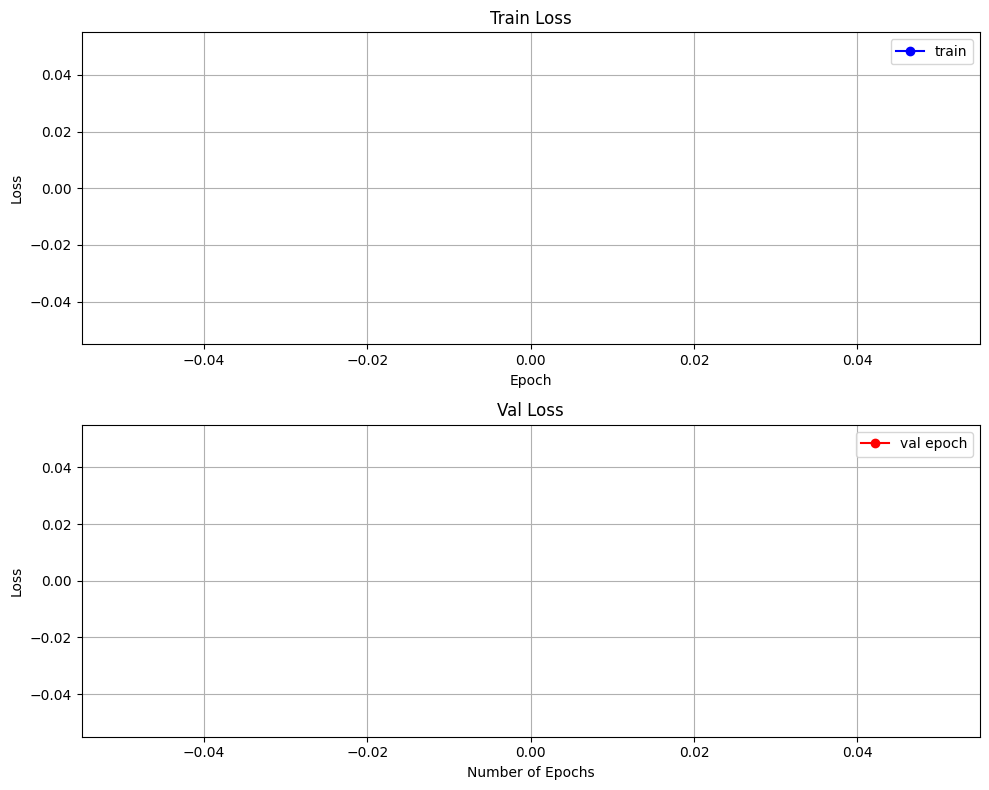

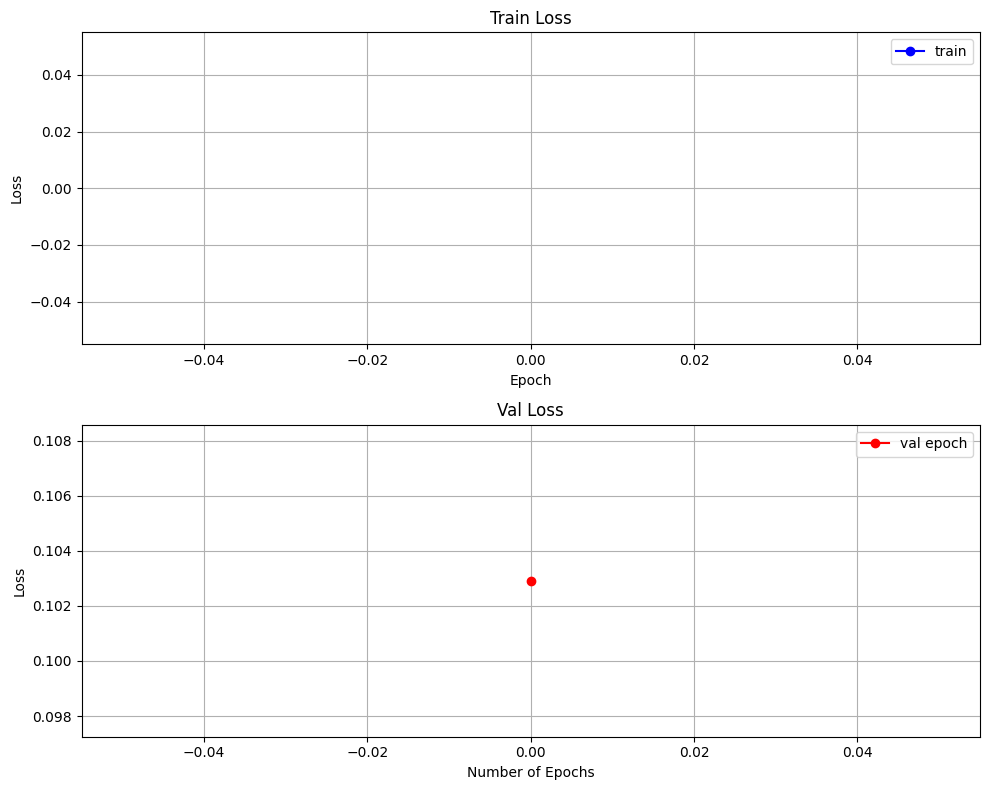

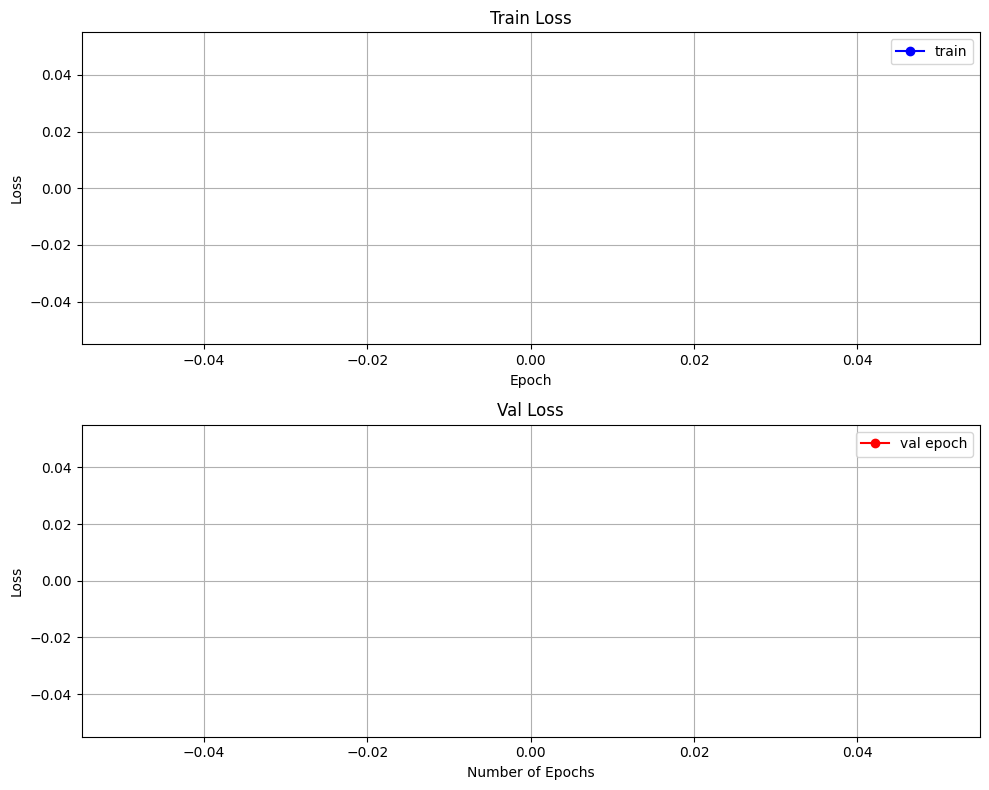

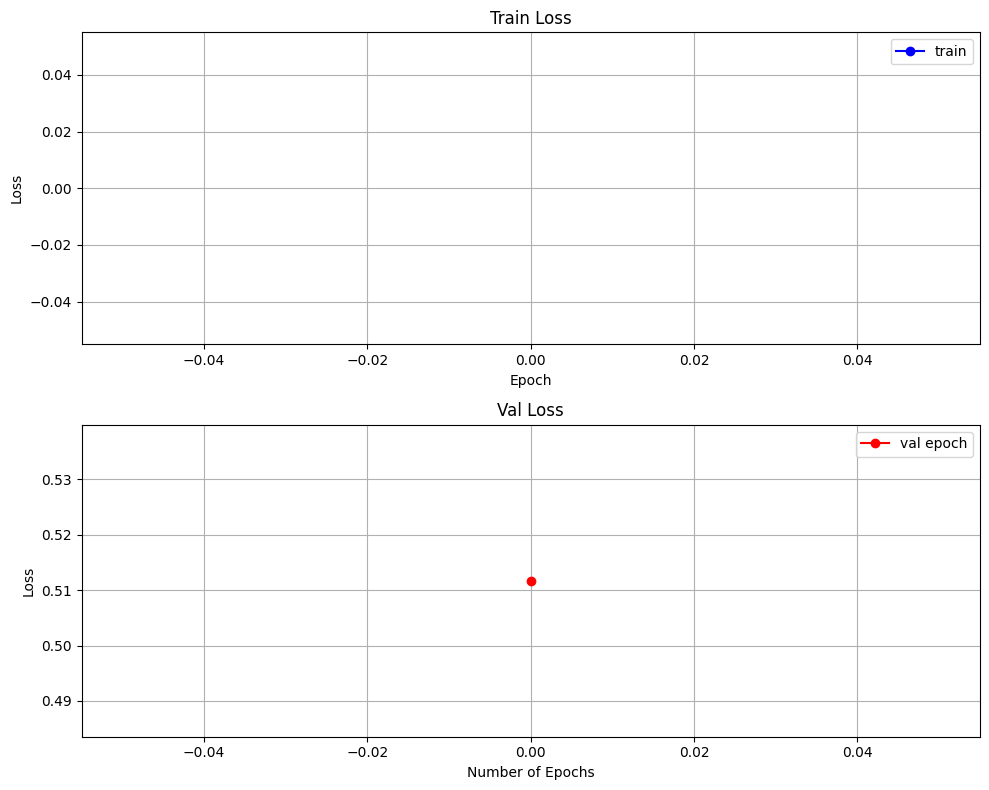

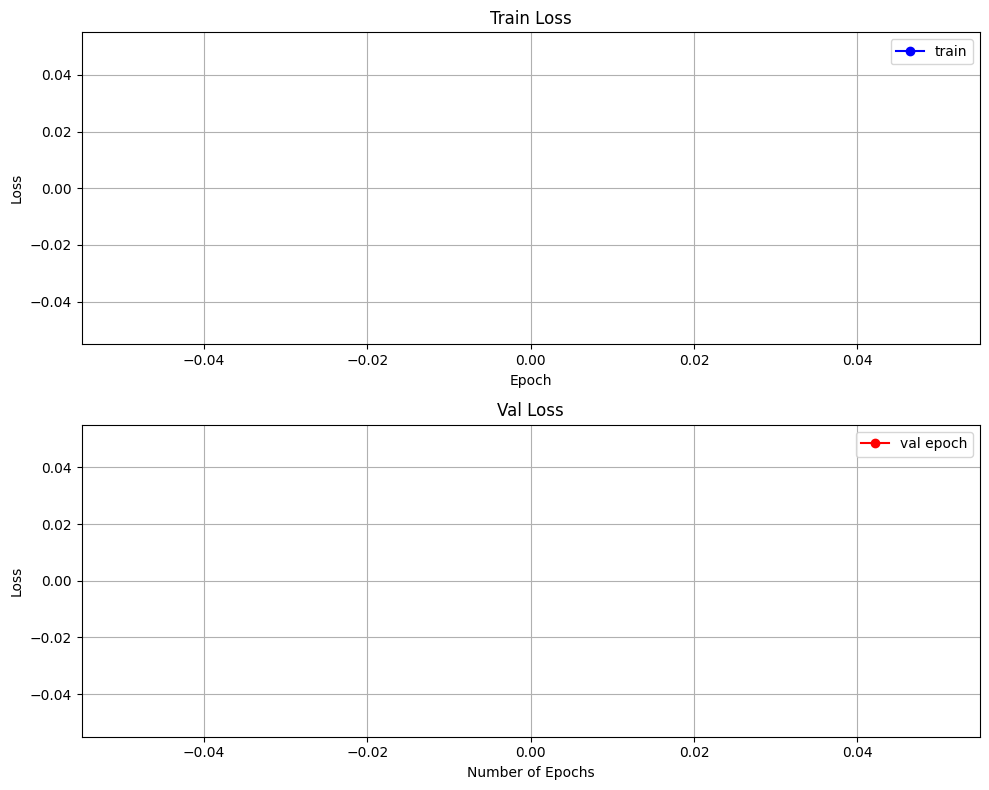

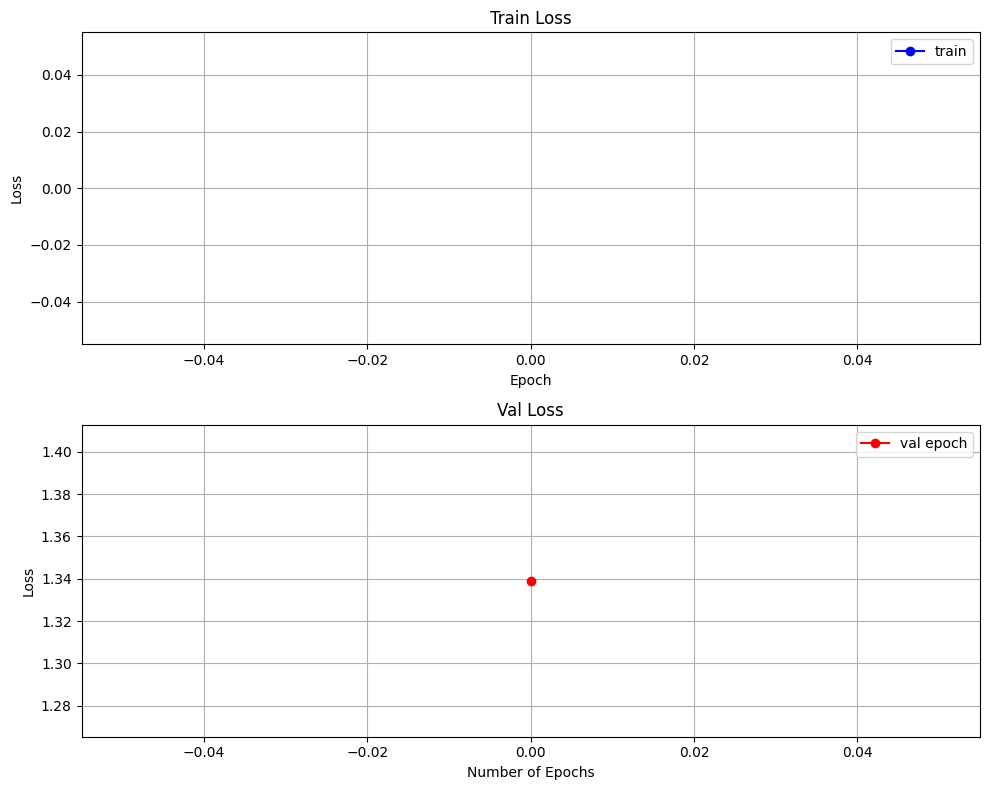

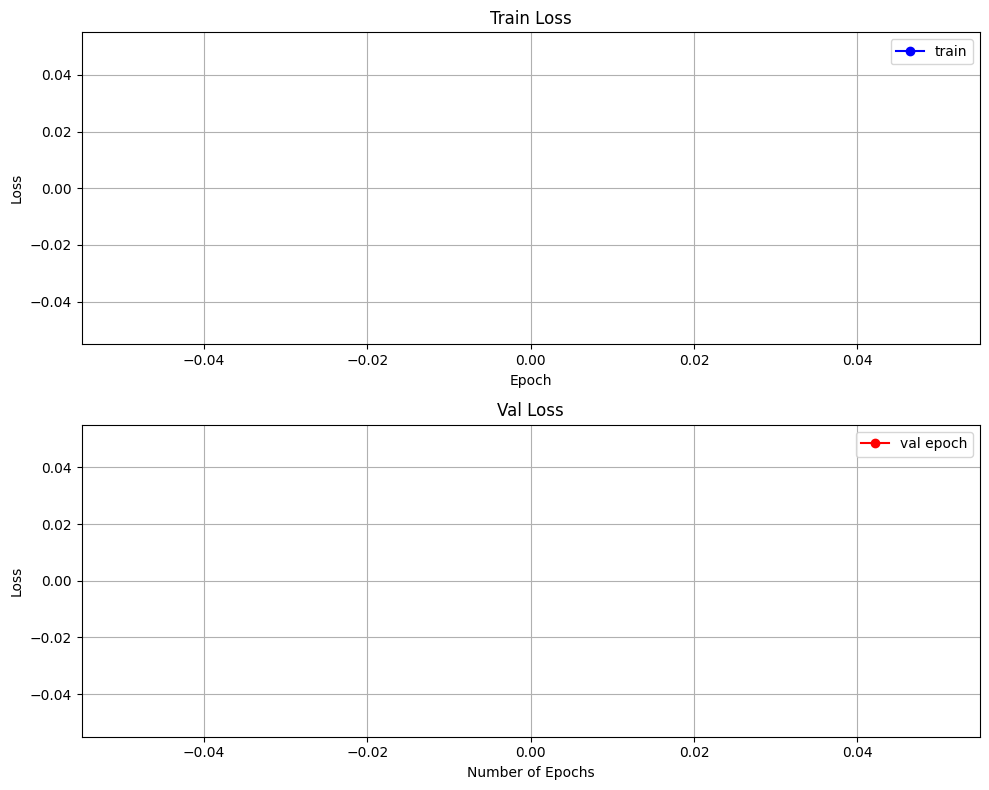

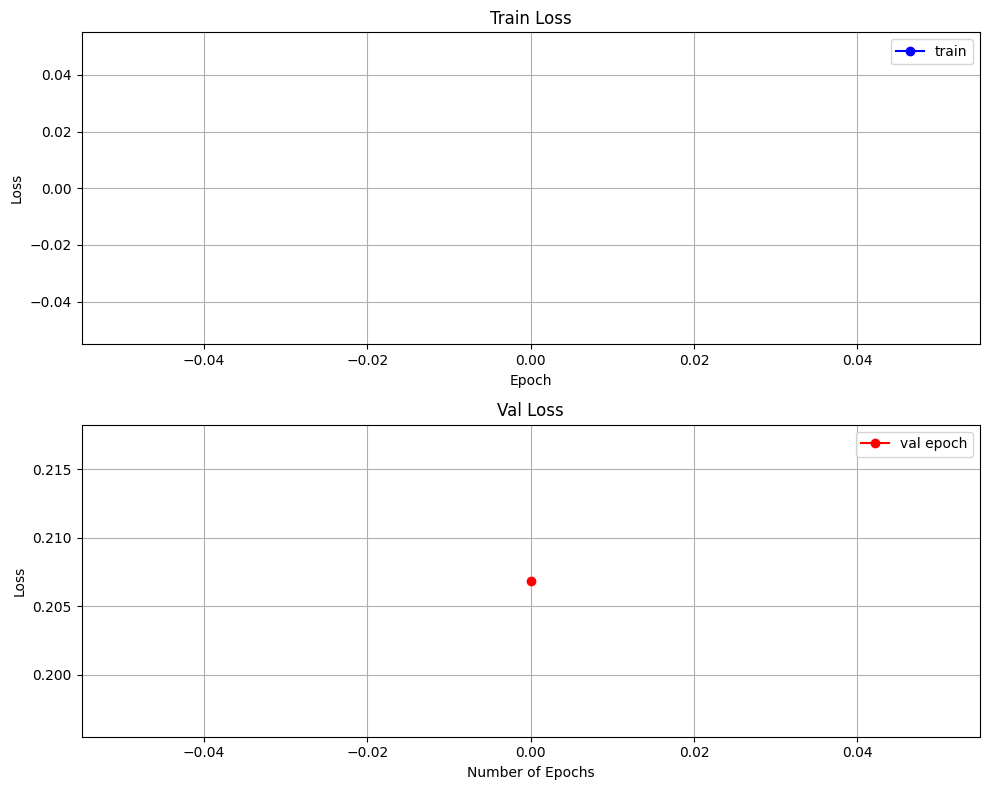

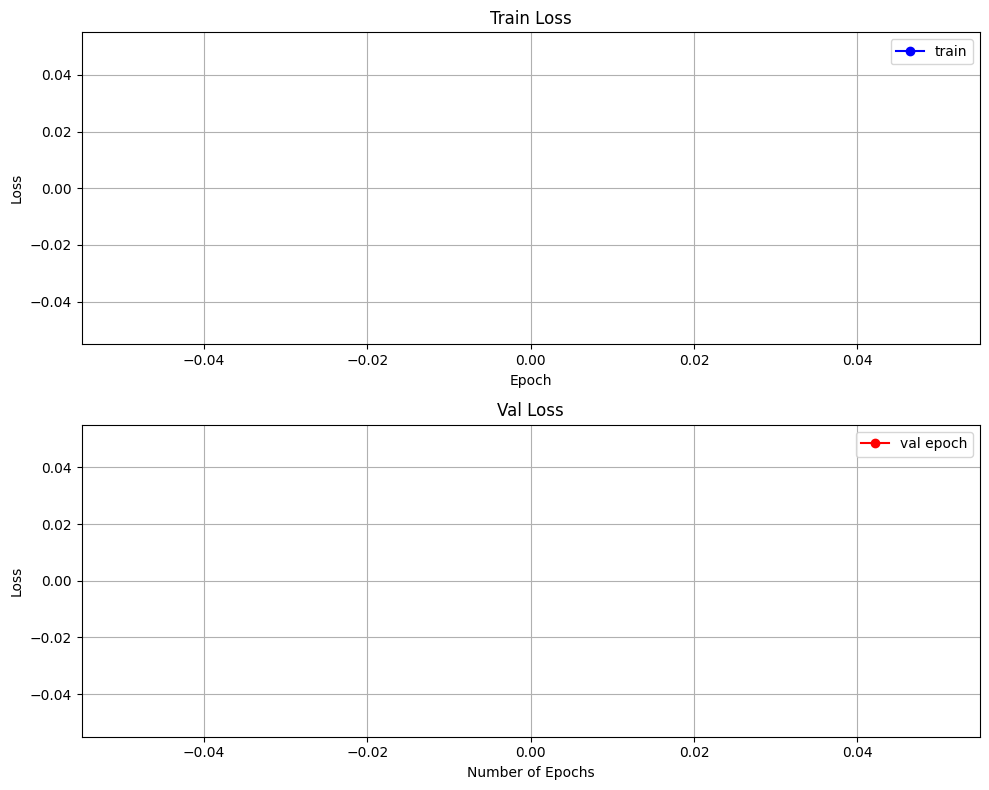

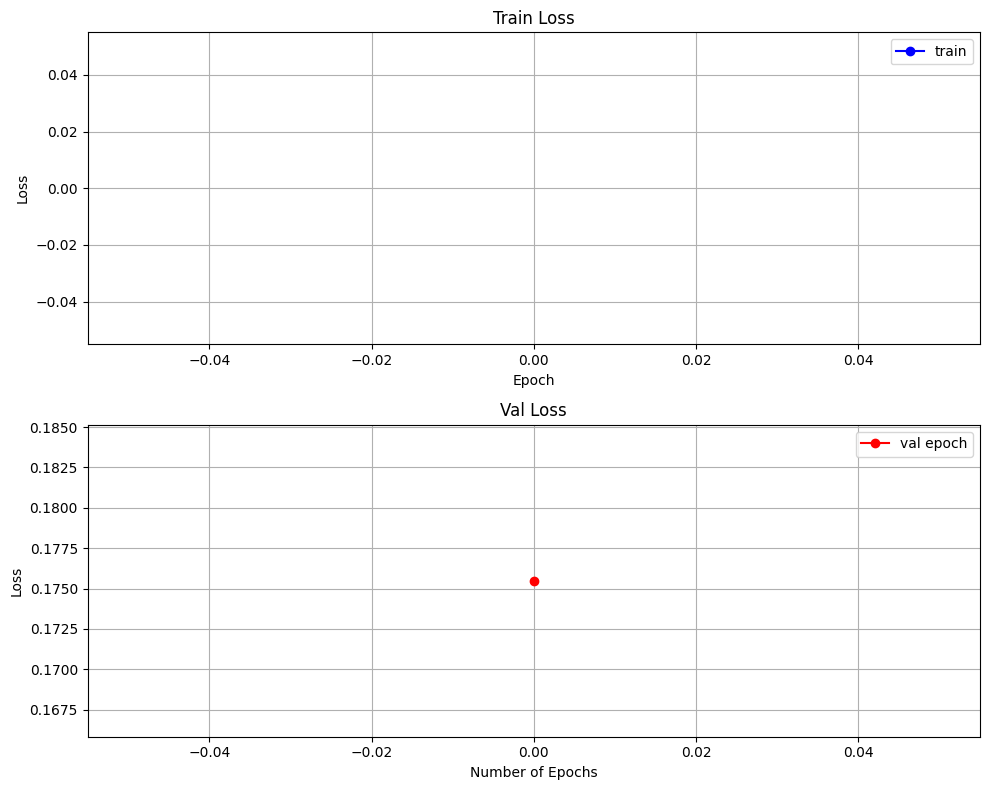

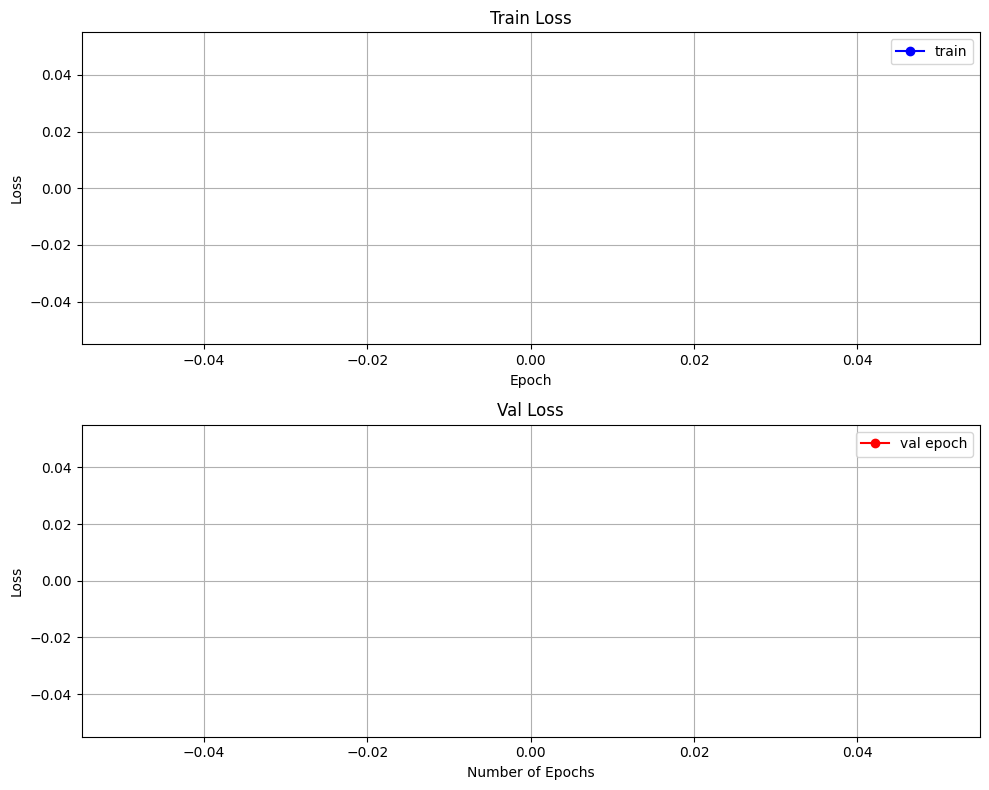

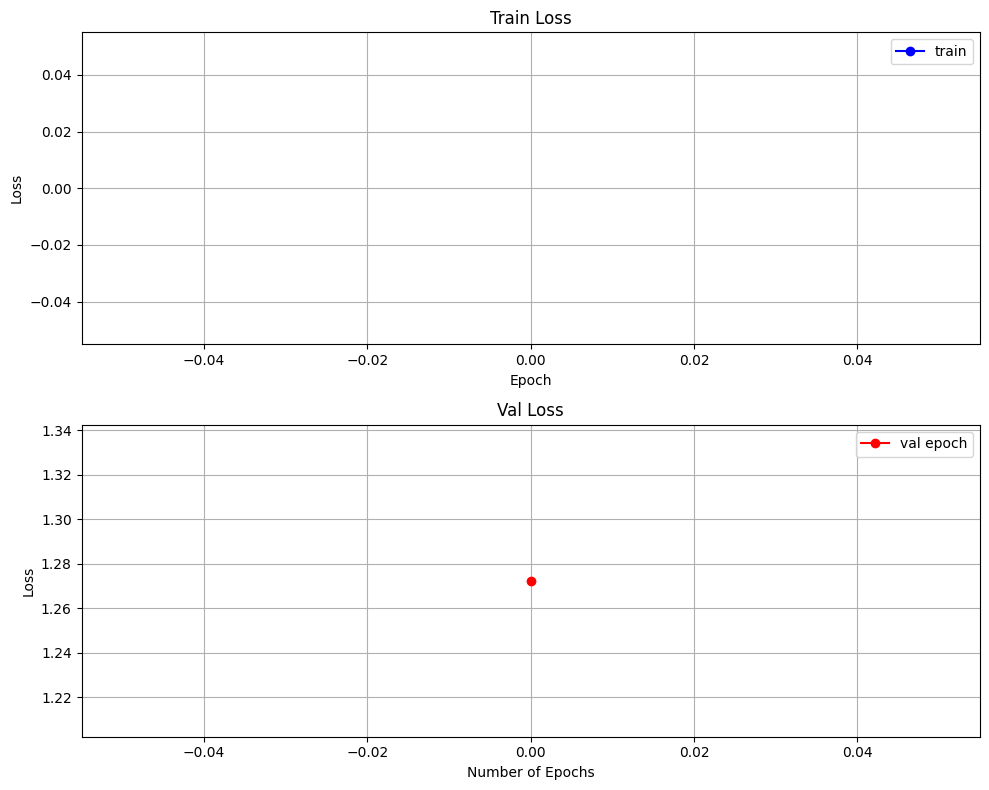

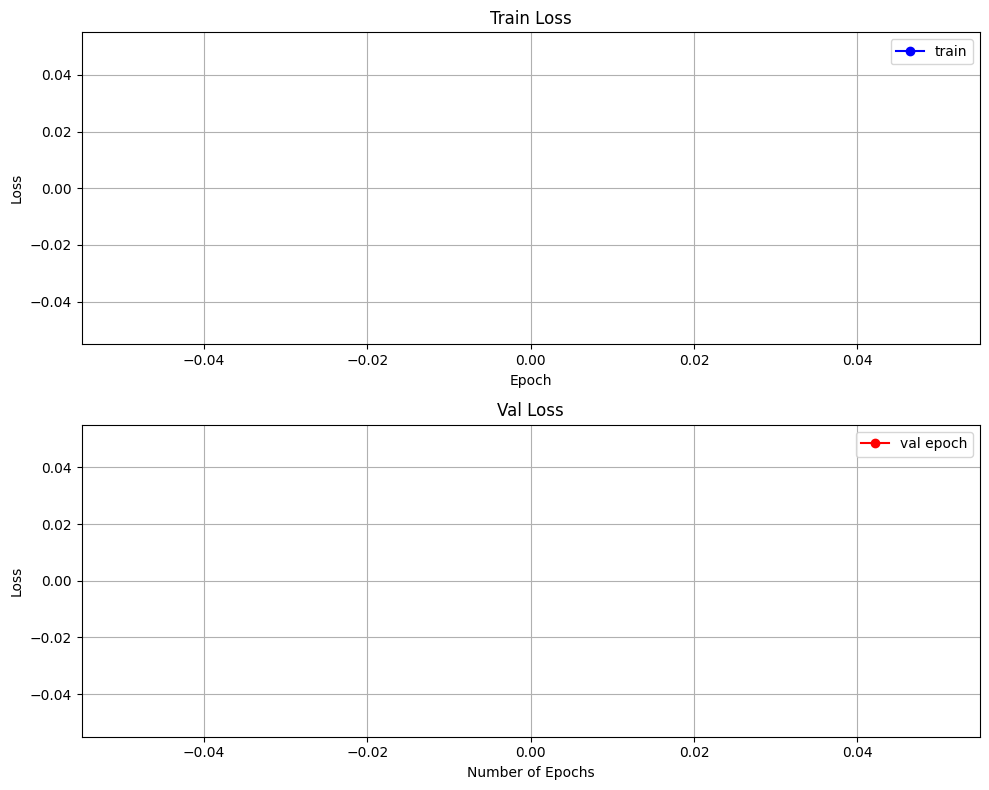

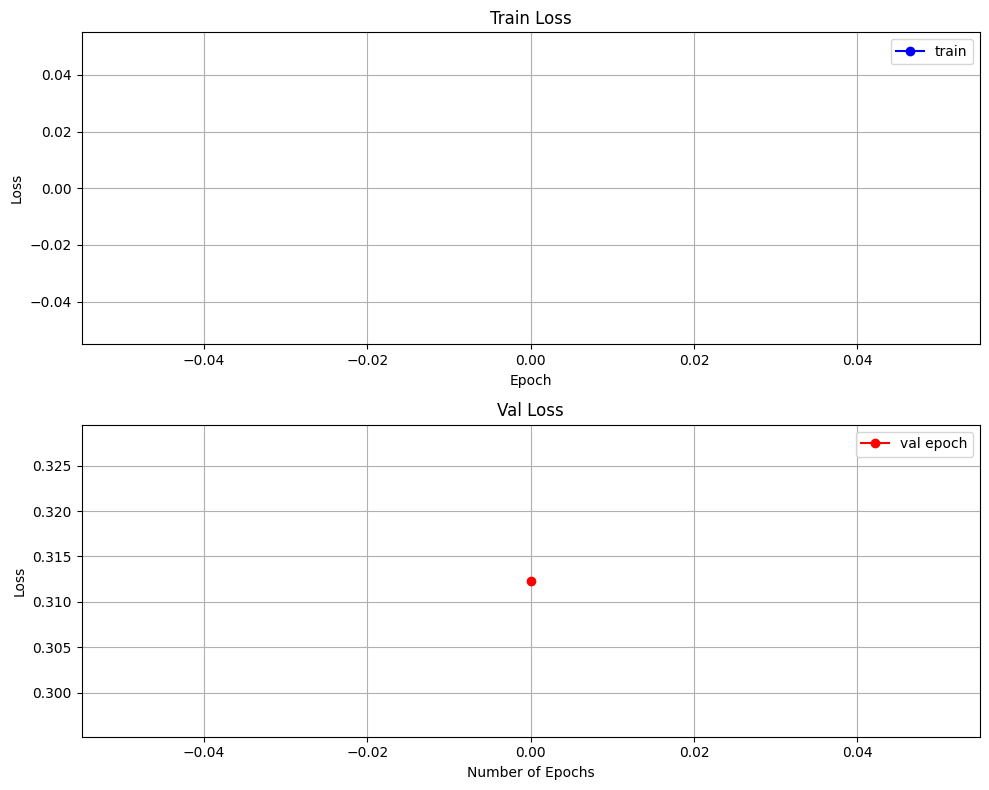

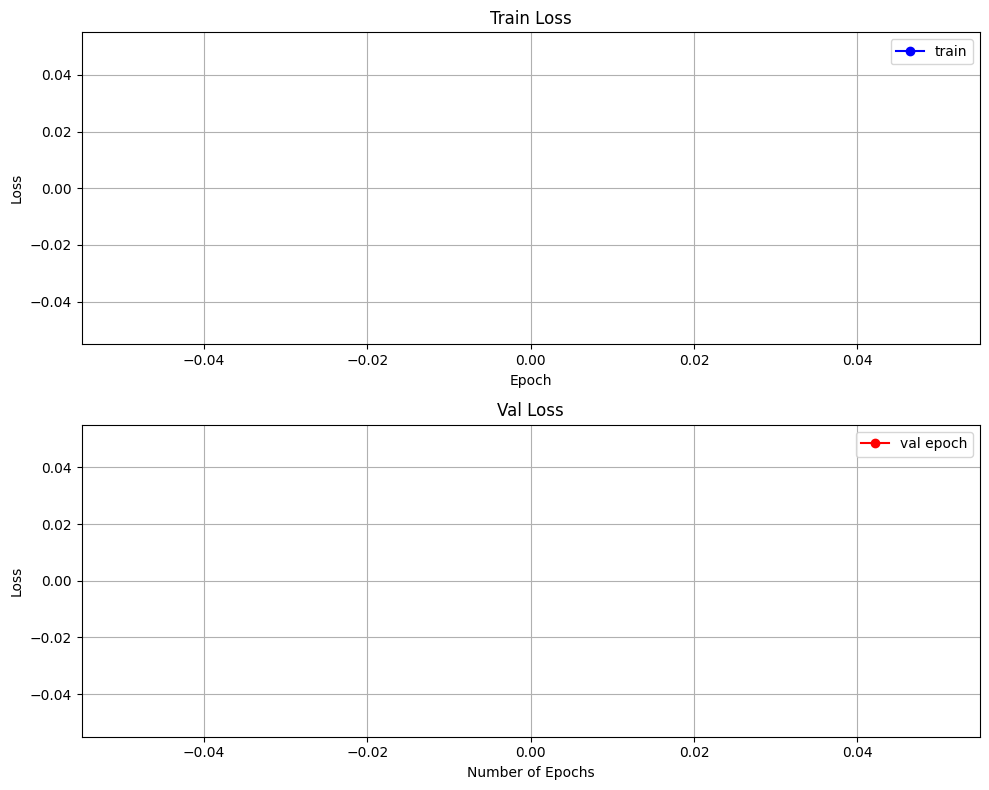

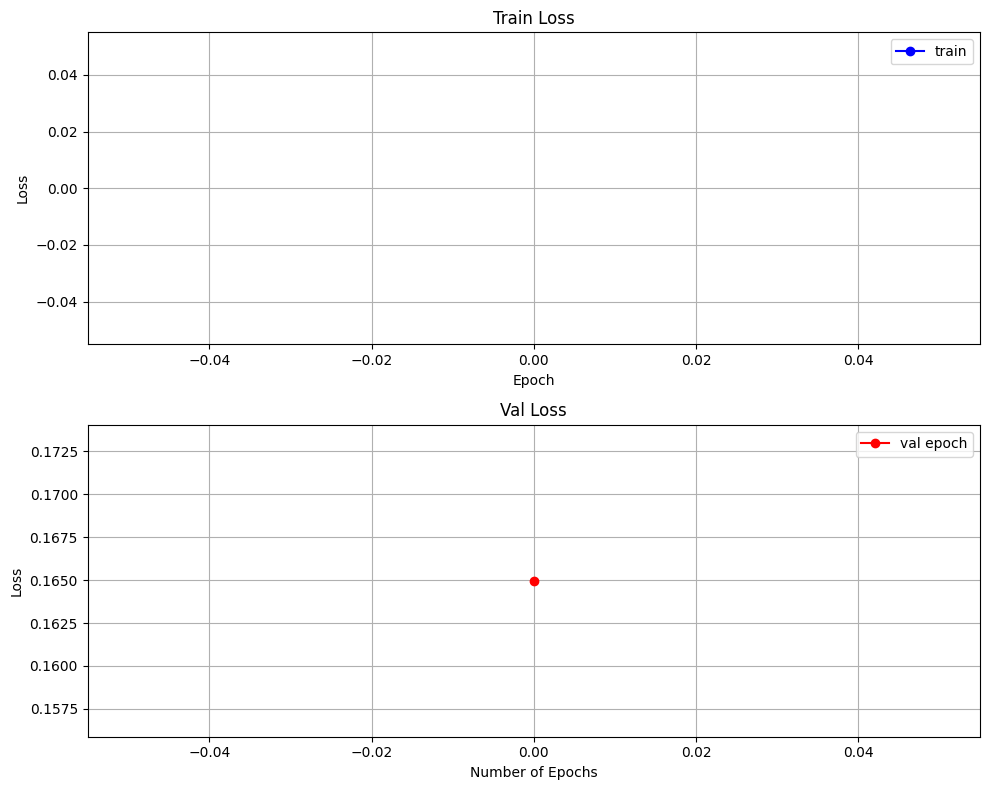

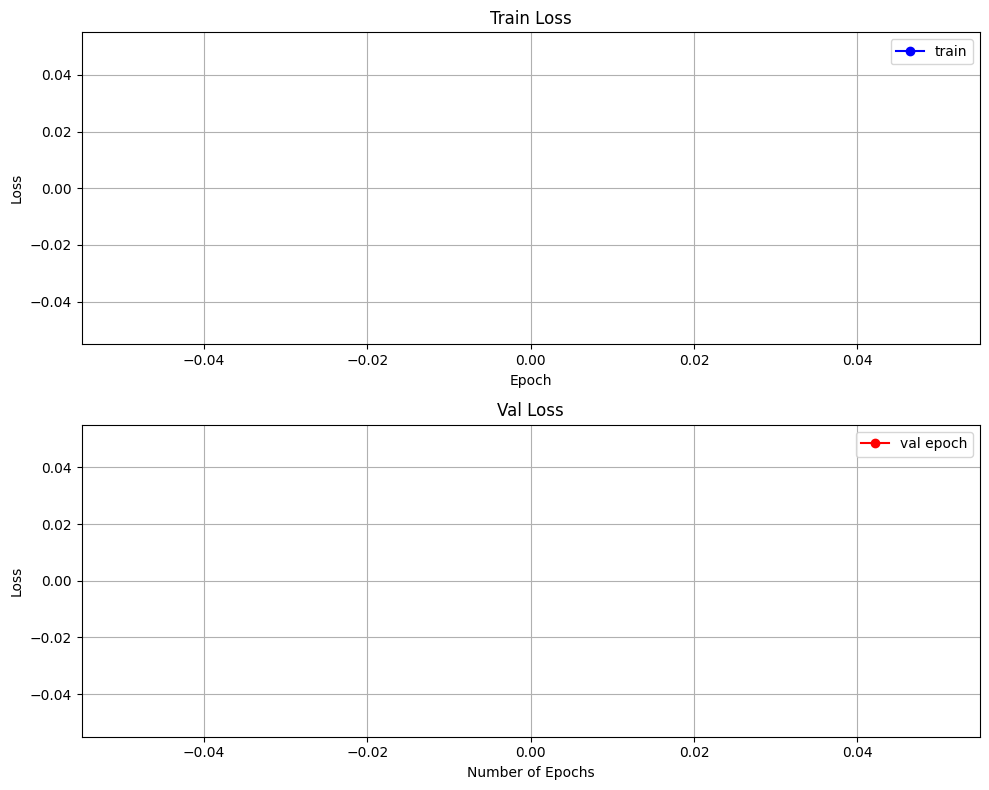

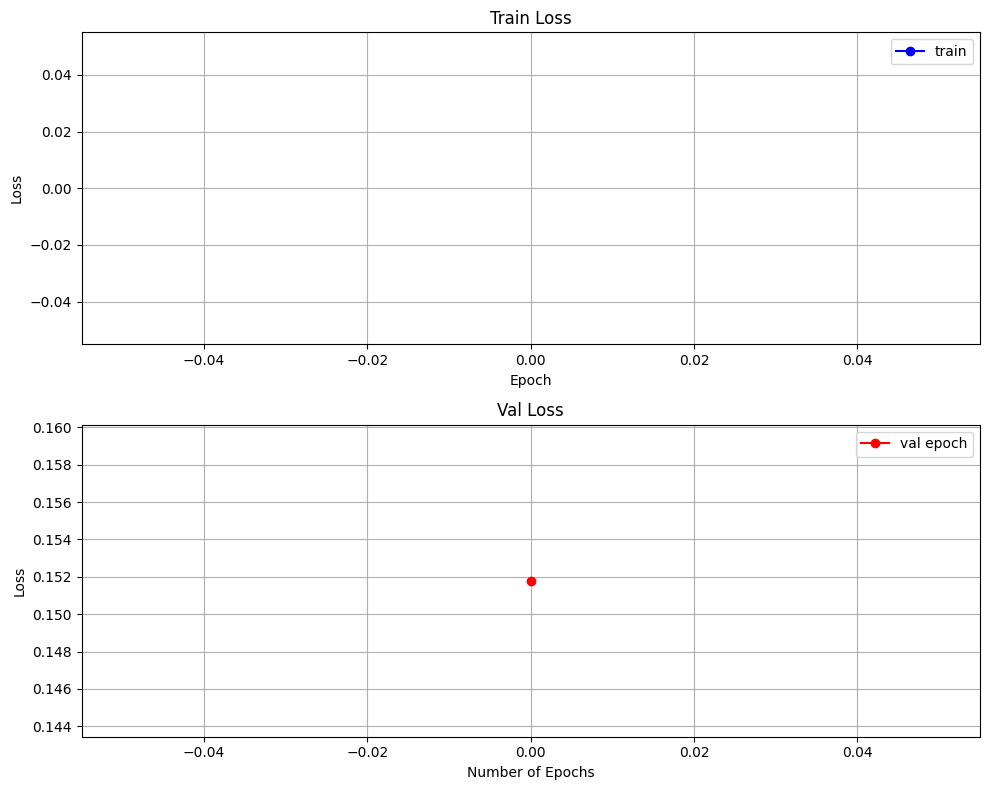

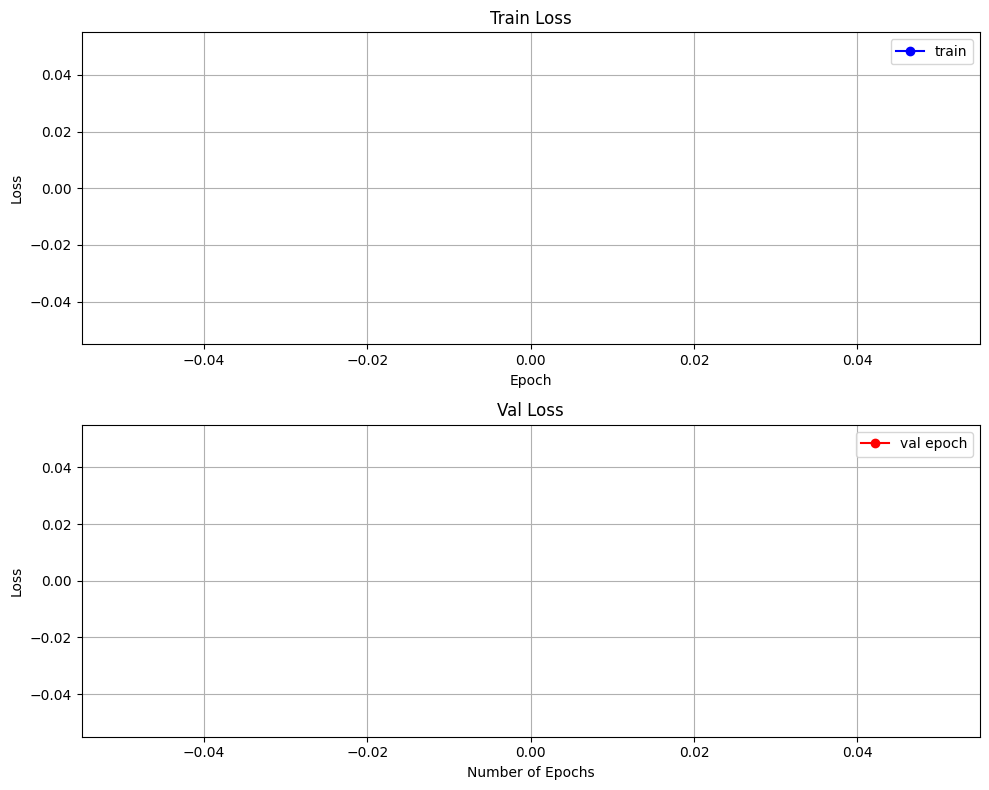

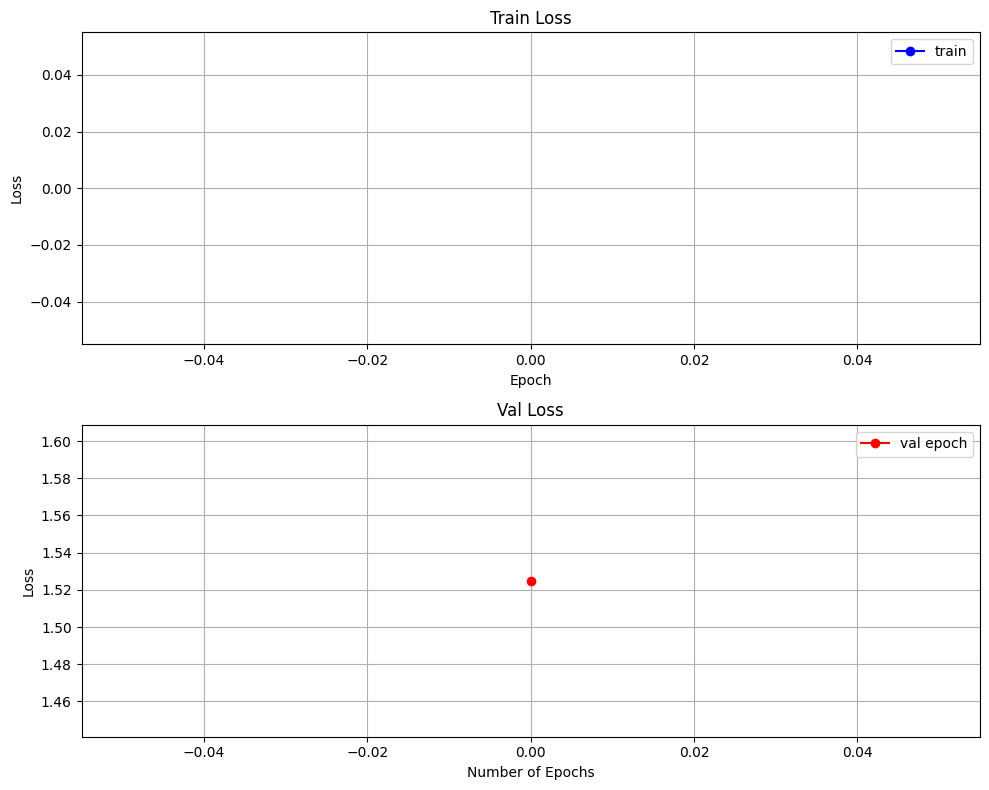

In [100]:
val_loss_pre = evaluate_n_train_iterations(folder_results=folder_results_with_pretraining, 
                            use_pretraining=True, 
                            n=10,
                            epochs=1)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type                             | Params
-----------------------------------------------------------------------
0 | linear            | Linear                           | 16.5 K
1 | linear_regression | Linear                           | 129   
2 | relu              | ReLU                             | 0     
3 | spectrum_encoder  | SpectrumTransformerEncoderCustom | 1.7 M 
4 | cos               | CosineSimilarity                 | 0     
5 | regression_loss   | MSELoss                          | 0     
6 | dropout           | Dropout                          | 0     
-----------------------------------------------------------------------
129       Trainable param

Sanity Checking: |                                                                                            …

Train loss:
[]
Validation loss
[0.17075330018997192]


Training: |                                                                                                   …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=1` reached.


Train loss:
[]
Validation loss
[0.17075330018997192, 0.1507617086172104]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type                             | Params
-----------------------------------------------------------------------
0 | linear            | Linear                           | 16.5 K
1 | linear_regression | Linear                           | 129   
2 | relu              | ReLU                             | 0     
3 | spectrum_encoder  | SpectrumTransformerEncoderCustom | 1.7 M 
4 | cos               | CosineSimilarity                 | 0     
5 | regression_loss   | MSELoss                          | 0     
6 | dropout           | Dropout                          | 0     
-----------------------------------------------------------------------
129       Trainable param

Sanity Checking: |                                                                                            …

Train loss:
[]
Validation loss
[1.4604254961013794]


Training: |                                                                                                   …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=1` reached.


Train loss:
[]
Validation loss
[1.4604254961013794, 1.231190800666809]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type                             | Params
-----------------------------------------------------------------------
0 | linear            | Linear                           | 16.5 K
1 | linear_regression | Linear                           | 129   
2 | relu              | ReLU                             | 0     
3 | spectrum_encoder  | SpectrumTransformerEncoderCustom | 1.7 M 
4 | cos               | CosineSimilarity                 | 0     
5 | regression_loss   | MSELoss                          | 0     
6 | dropout           | Dropout                          | 0     
-----------------------------------------------------------------------
129       Trainable param

Sanity Checking: |                                                                                            …

Train loss:
[]
Validation loss
[0.2876204550266266]


Training: |                                                                                                   …

Validation: |                                                                                                 …

Train loss:
[]
Validation loss
[0.2876204550266266, 0.2544535994529724]


`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type                             | Params
-----------------------------------------------------------------------
0 | linear            | Linear                           | 16.5 K
1 | linear_regression | Linear                           | 129   
2 | relu              | ReLU                             | 0     
3 | spectrum_encoder  | SpectrumTransformerEncoderCustom | 1.7 M 
4 | cos               | CosineSimilarity                 | 0     
5 | regression_loss   | MSELoss                          | 0     
6 | dropout           | Dropout                          | 0     
--------------------------------------------------

Sanity Checking: |                                                                                            …

Train loss:
[]
Validation loss
[0.1043744832277298]


Training: |                                                                                                   …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=1` reached.


Train loss:
[]
Validation loss
[0.1043744832277298, 0.09678689390420914]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type                             | Params
-----------------------------------------------------------------------
0 | linear            | Linear                           | 16.5 K
1 | linear_regression | Linear                           | 129   
2 | relu              | ReLU                             | 0     
3 | spectrum_encoder  | SpectrumTransformerEncoderCustom | 1.7 M 
4 | cos               | CosineSimilarity                 | 0     
5 | regression_loss   | MSELoss                          | 0     
6 | dropout           | Dropout                          | 0     
-----------------------------------------------------------------------
129       Trainable param

Sanity Checking: |                                                                                            …

Train loss:
[]
Validation loss
[0.1845102608203888]


Training: |                                                                                                   …

Validation: |                                                                                                 …

Train loss:
[]
Validation loss
[0.1845102608203888, 0.15315163135528564]


`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type                             | Params
-----------------------------------------------------------------------
0 | linear            | Linear                           | 16.5 K
1 | linear_regression | Linear                           | 129   
2 | relu              | ReLU                             | 0     
3 | spectrum_encoder  | SpectrumTransformerEncoderCustom | 1.7 M 
4 | cos               | CosineSimilarity                 | 0     
5 | regression_loss   | MSELoss                          | 0     
6 | dropout           | Dropout                          | 0     
--------------------------------------------------

Sanity Checking: |                                                                                            …

Train loss:
[]
Validation loss
[0.8536064624786377]


Training: |                                                                                                   …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=1` reached.


Train loss:
[]
Validation loss
[0.8536064624786377, 0.7366828322410583]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type                             | Params
-----------------------------------------------------------------------
0 | linear            | Linear                           | 16.5 K
1 | linear_regression | Linear                           | 129   
2 | relu              | ReLU                             | 0     
3 | spectrum_encoder  | SpectrumTransformerEncoderCustom | 1.7 M 
4 | cos               | CosineSimilarity                 | 0     
5 | regression_loss   | MSELoss                          | 0     
6 | dropout           | Dropout                          | 0     
-----------------------------------------------------------------------
129       Trainable param

Sanity Checking: |                                                                                            …

Train loss:
[]
Validation loss
[0.6694258451461792]


Training: |                                                                                                   …

Validation: |                                                                                                 …

Train loss:
[]
Validation loss
[0.6694258451461792, 0.5896322727203369]


`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type                             | Params
-----------------------------------------------------------------------
0 | linear            | Linear                           | 16.5 K
1 | linear_regression | Linear                           | 129   
2 | relu              | ReLU                             | 0     
3 | spectrum_encoder  | SpectrumTransformerEncoderCustom | 1.7 M 
4 | cos               | CosineSimilarity                 | 0     
5 | regression_loss   | MSELoss                          | 0     
6 | dropout           | Dropout                          | 0     
--------------------------------------------------

Sanity Checking: |                                                                                            …

Train loss:
[]
Validation loss
[0.1010567843914032]


Training: |                                                                                                   …

Validation: |                                                                                                 …

Train loss:
[]
Validation loss
[0.1010567843914032, 0.10347609221935272]


`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type                             | Params
-----------------------------------------------------------------------
0 | linear            | Linear                           | 16.5 K
1 | linear_regression | Linear                           | 129   
2 | relu              | ReLU                             | 0     
3 | spectrum_encoder  | SpectrumTransformerEncoderCustom | 1.7 M 
4 | cos               | CosineSimilarity                 | 0     
5 | regression_loss   | MSELoss                          | 0     
6 | dropout           | Dropout                          | 0     
--------------------------------------------------

Sanity Checking: |                                                                                            …

Train loss:
[]
Validation loss
[0.7548697590827942]


Training: |                                                                                                   …

Validation: |                                                                                                 …

Train loss:
[]
Validation loss
[0.7548697590827942, 0.6931296586990356]


`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type                             | Params
-----------------------------------------------------------------------
0 | linear            | Linear                           | 16.5 K
1 | linear_regression | Linear                           | 129   
2 | relu              | ReLU                             | 0     
3 | spectrum_encoder  | SpectrumTransformerEncoderCustom | 1.7 M 
4 | cos               | CosineSimilarity                 | 0     
5 | regression_loss   | MSELoss                          | 0     
6 | dropout           | Dropout                          | 0     
--------------------------------------------------

Sanity Checking: |                                                                                            …

Train loss:
[]
Validation loss
[1.0626652240753174]


Training: |                                                                                                   …

Validation: |                                                                                                 …

Train loss:
[]
Validation loss
[1.0626652240753174, 0.9694864153862]


`Trainer.fit` stopped: `max_epochs=1` reached.


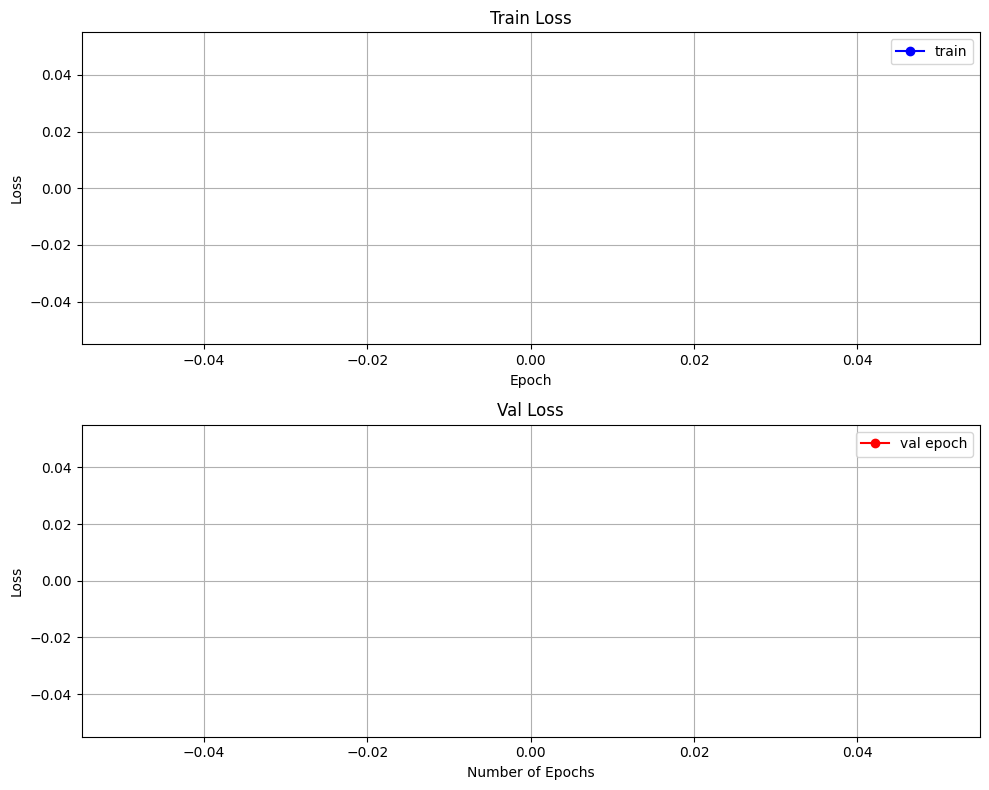

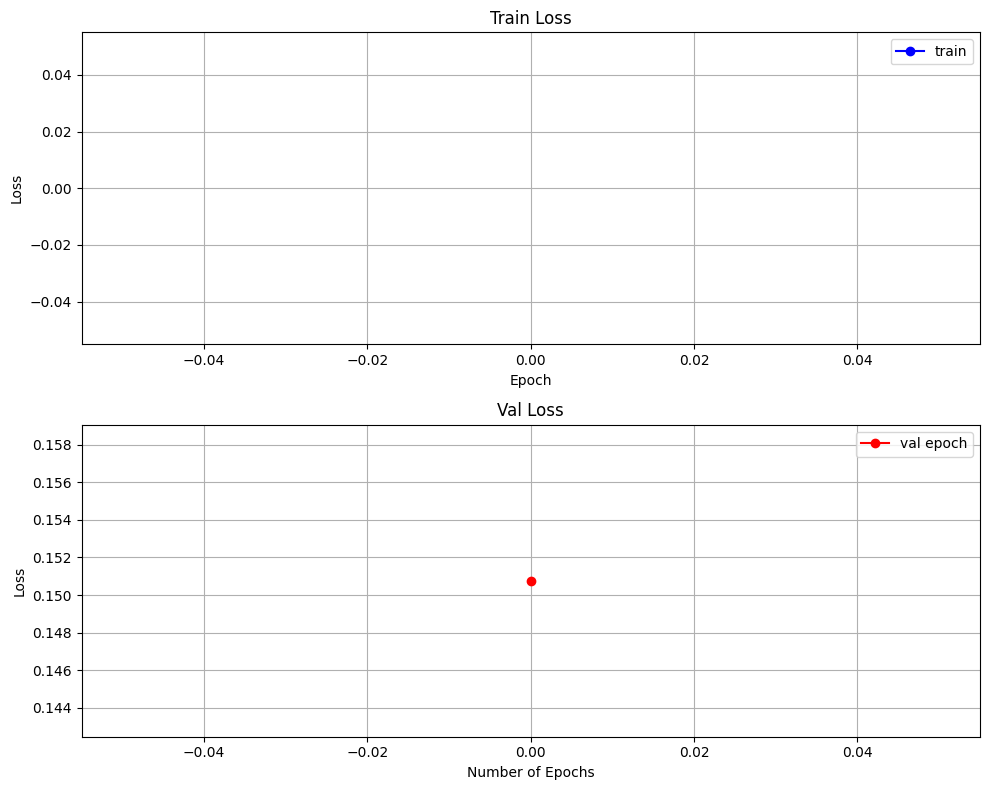

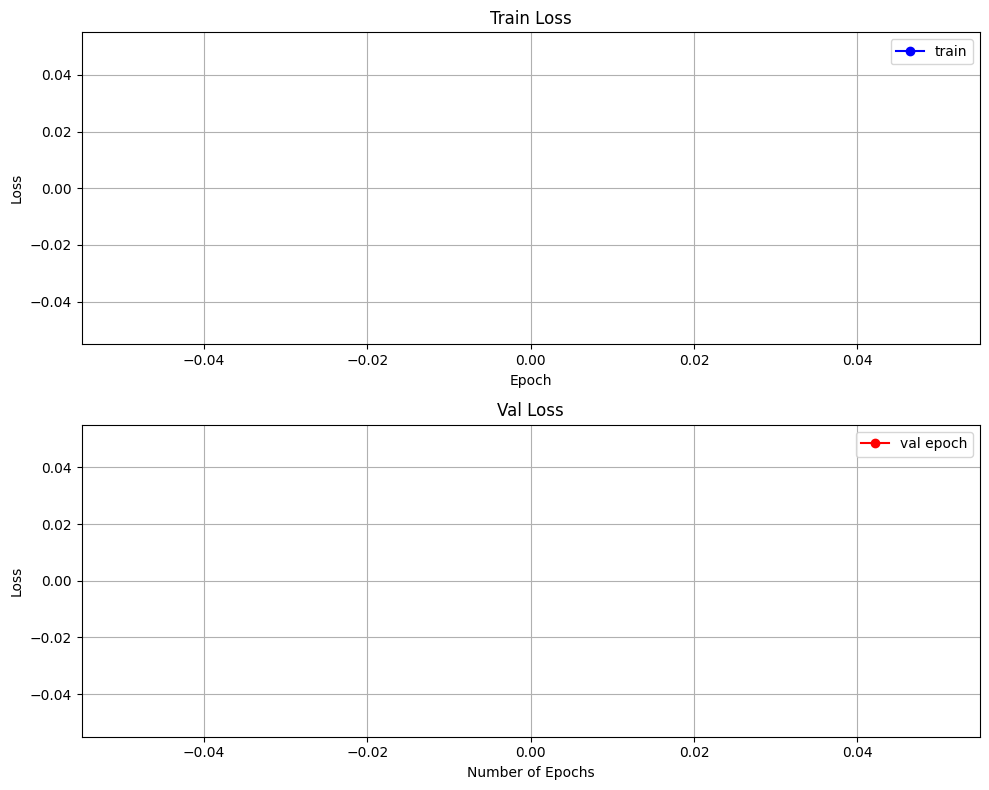

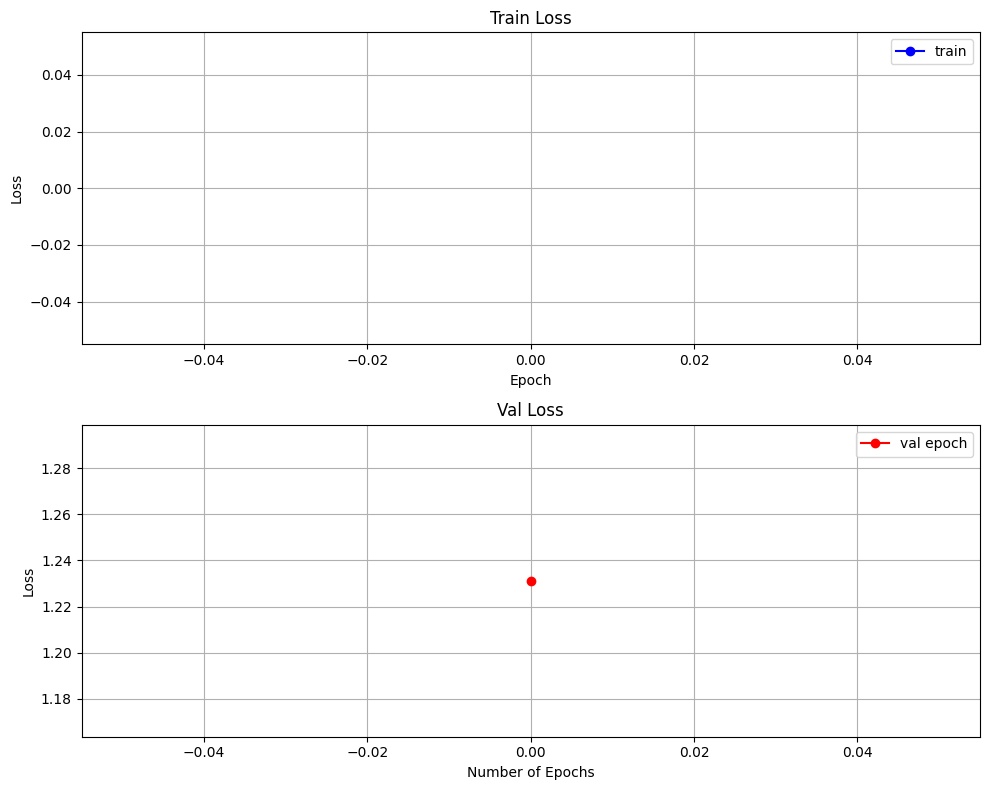

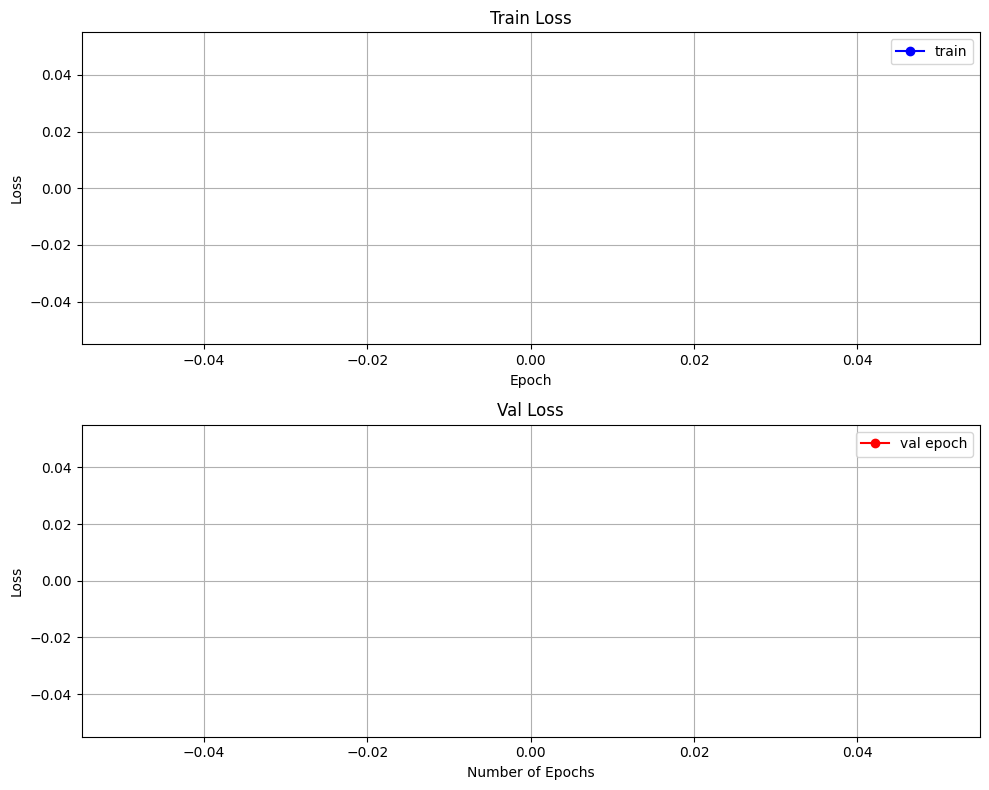

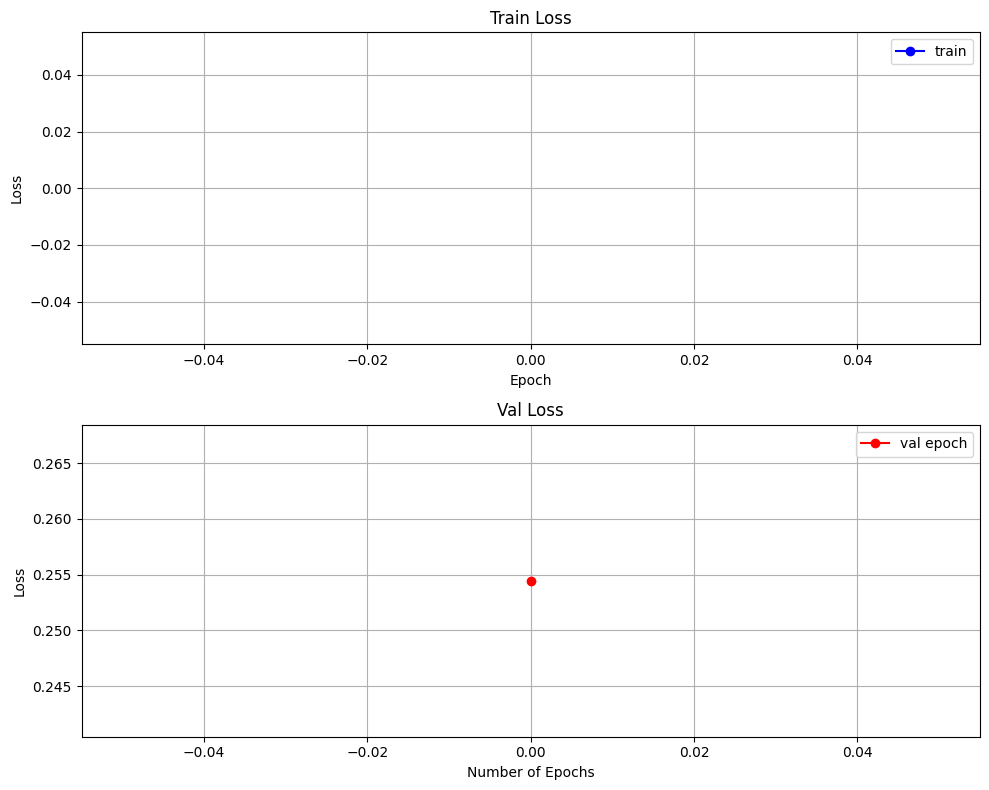

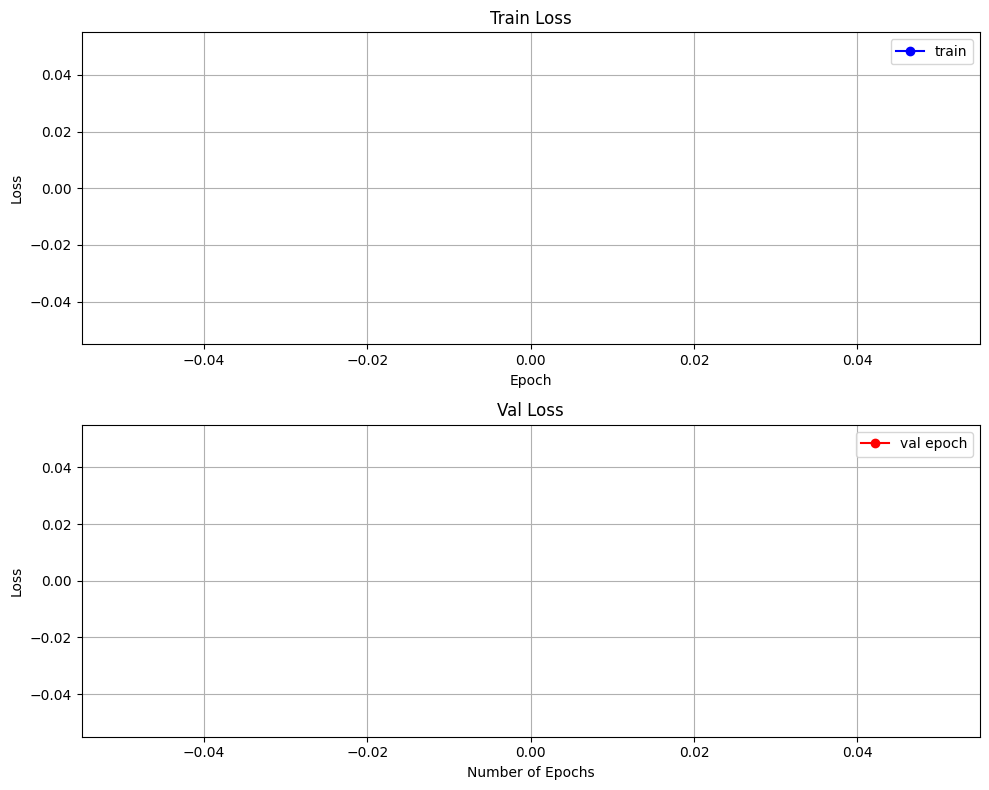

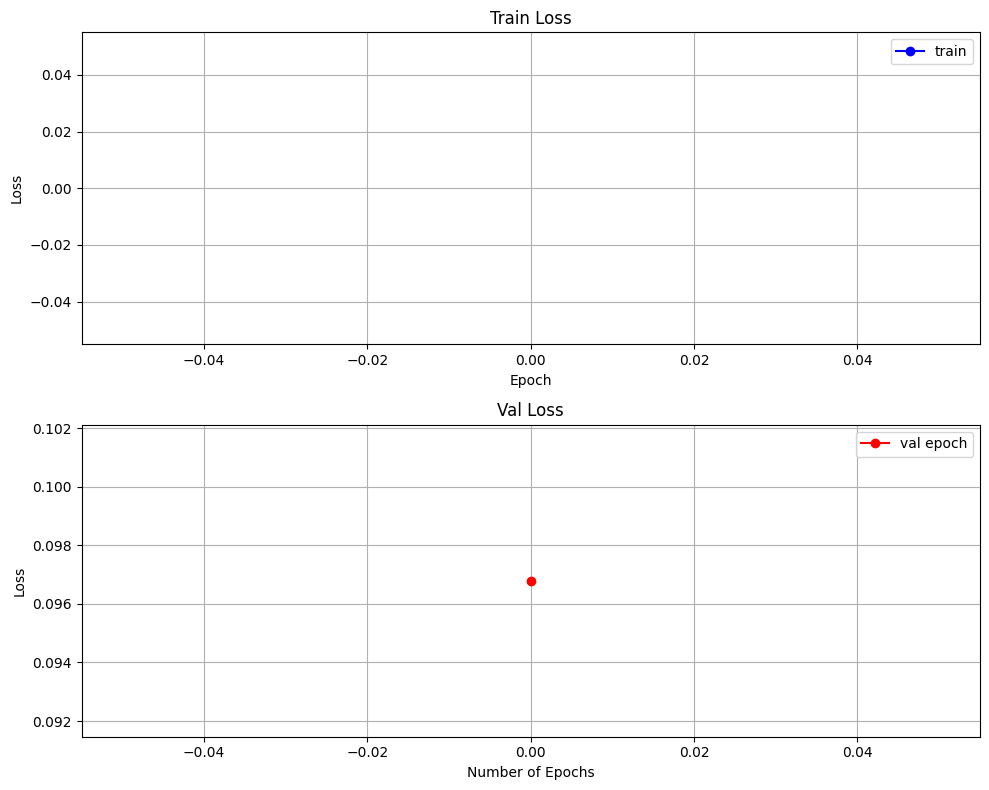

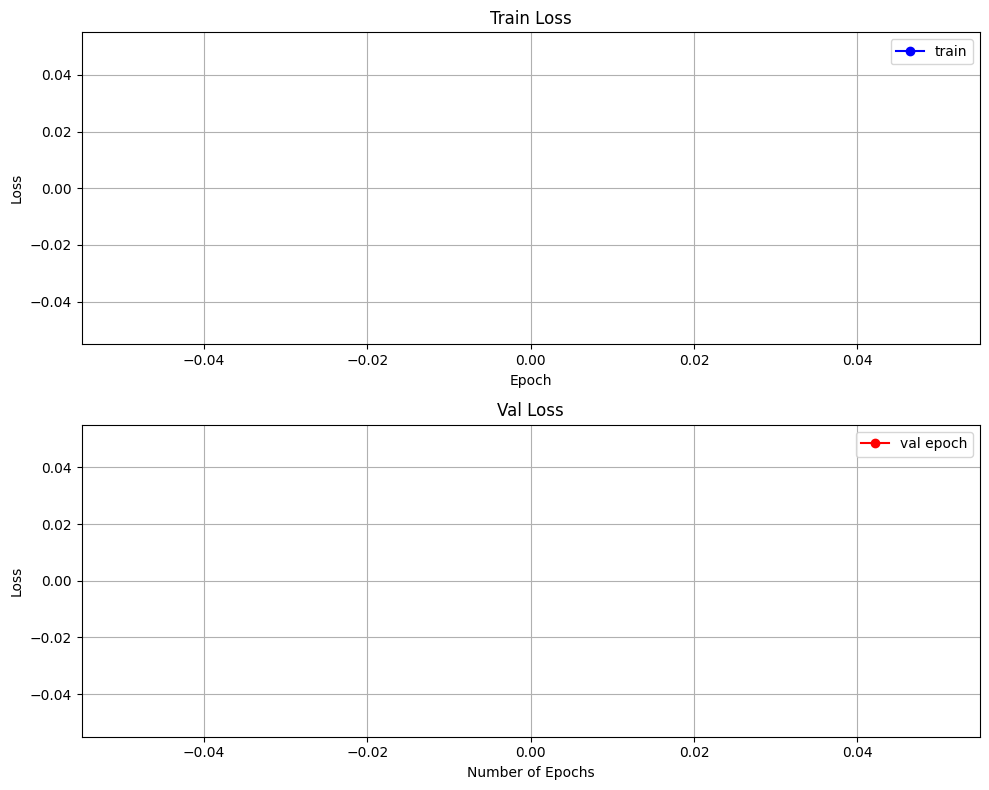

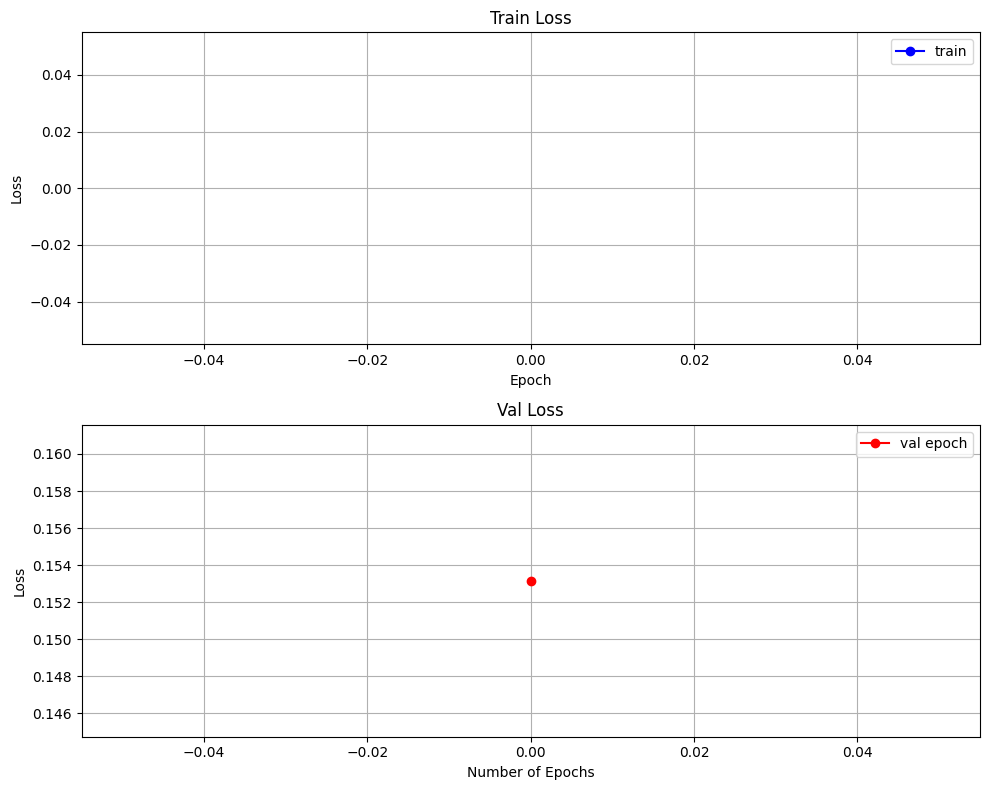

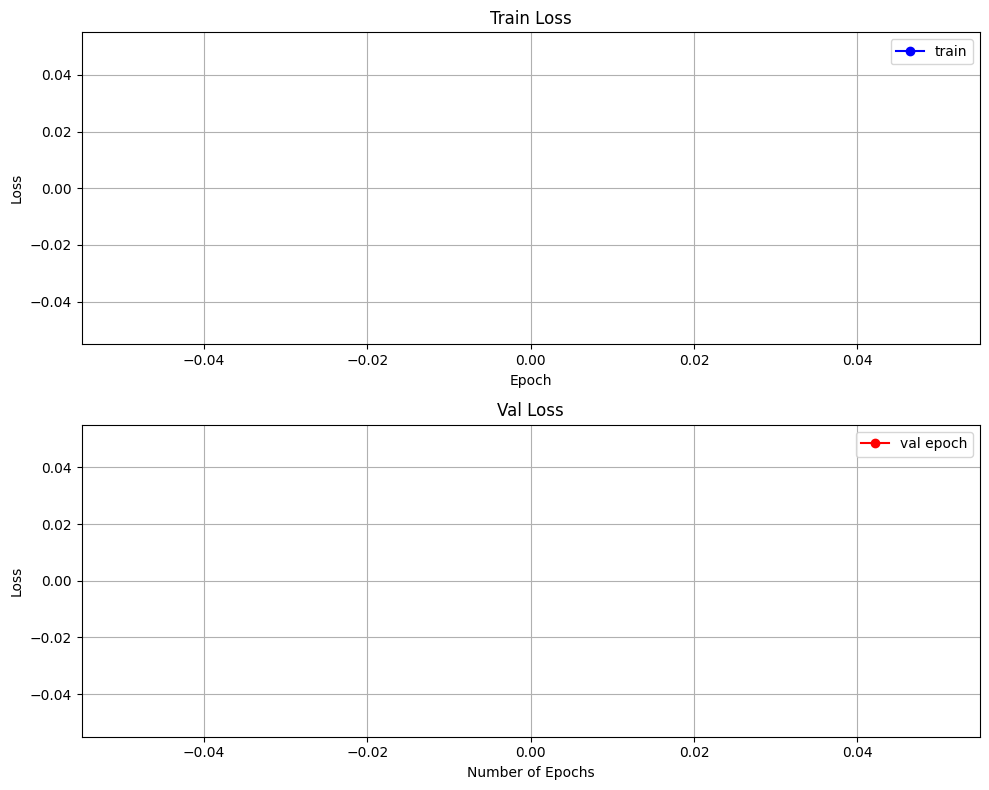

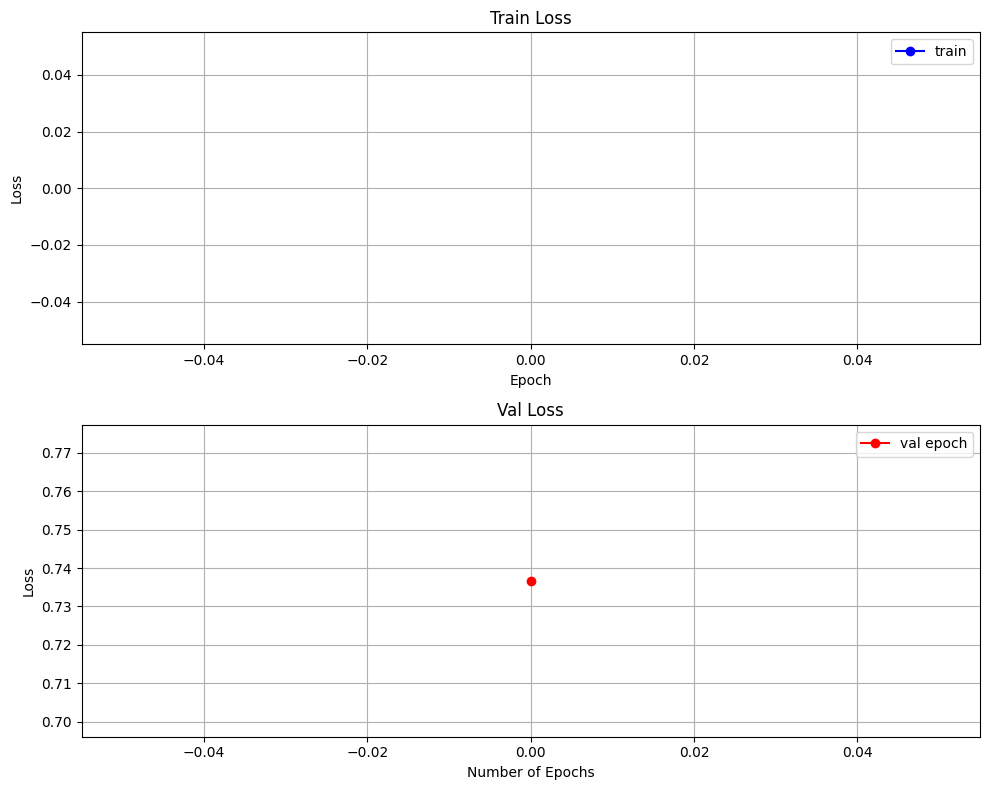

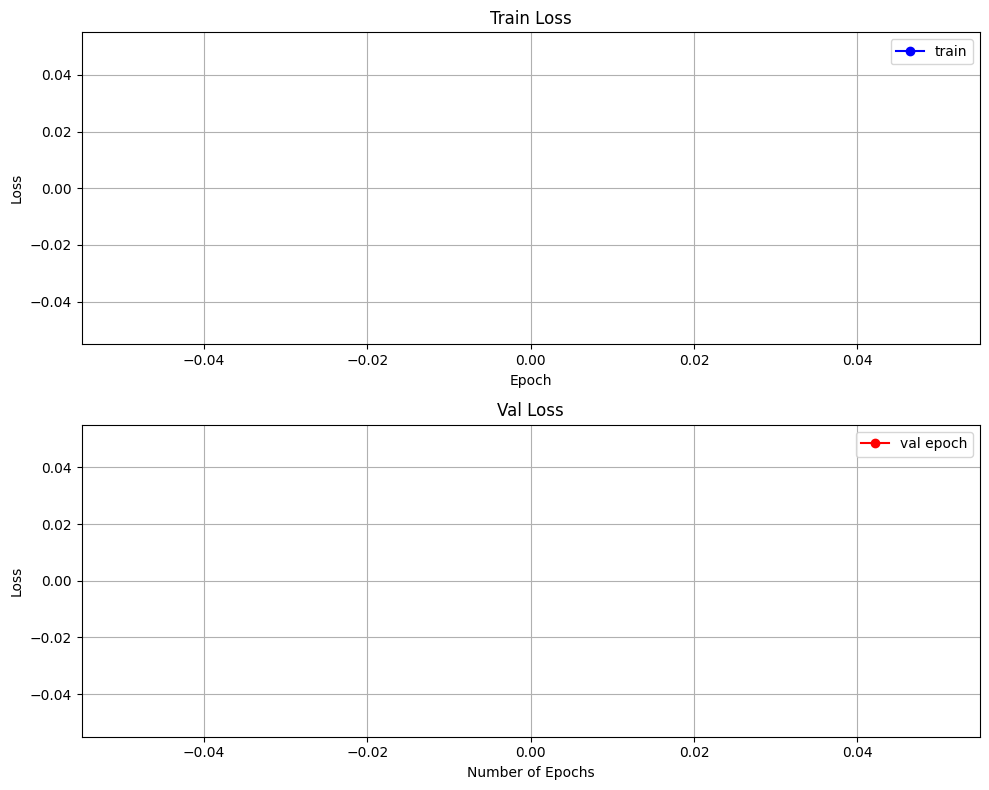

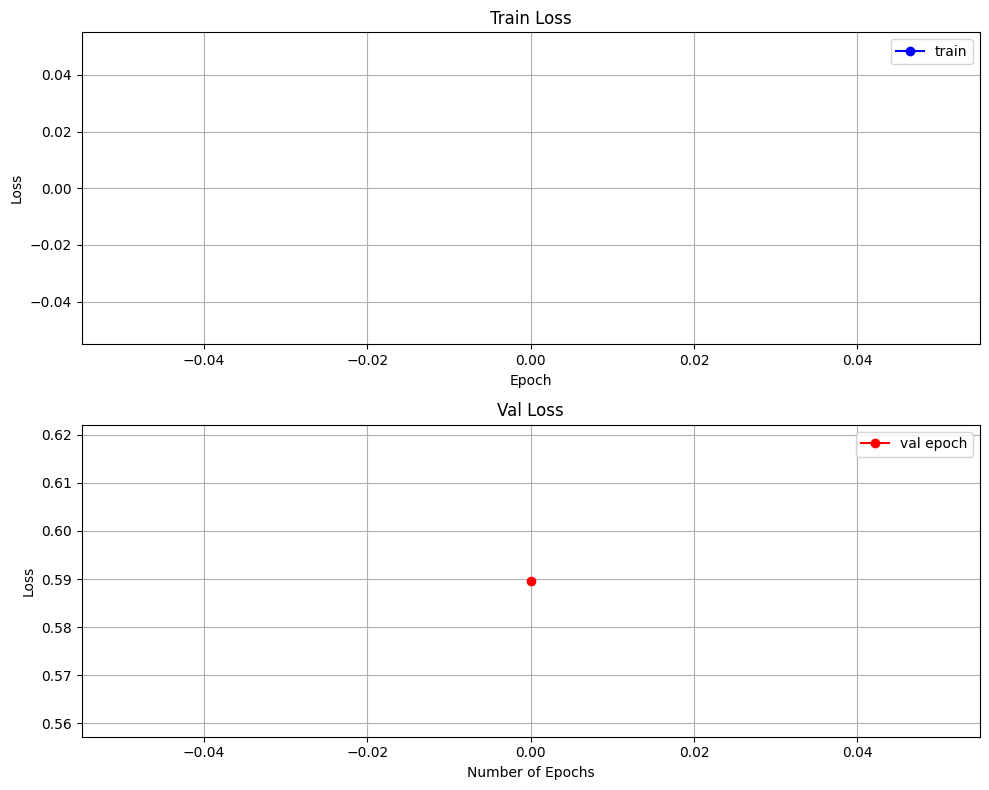

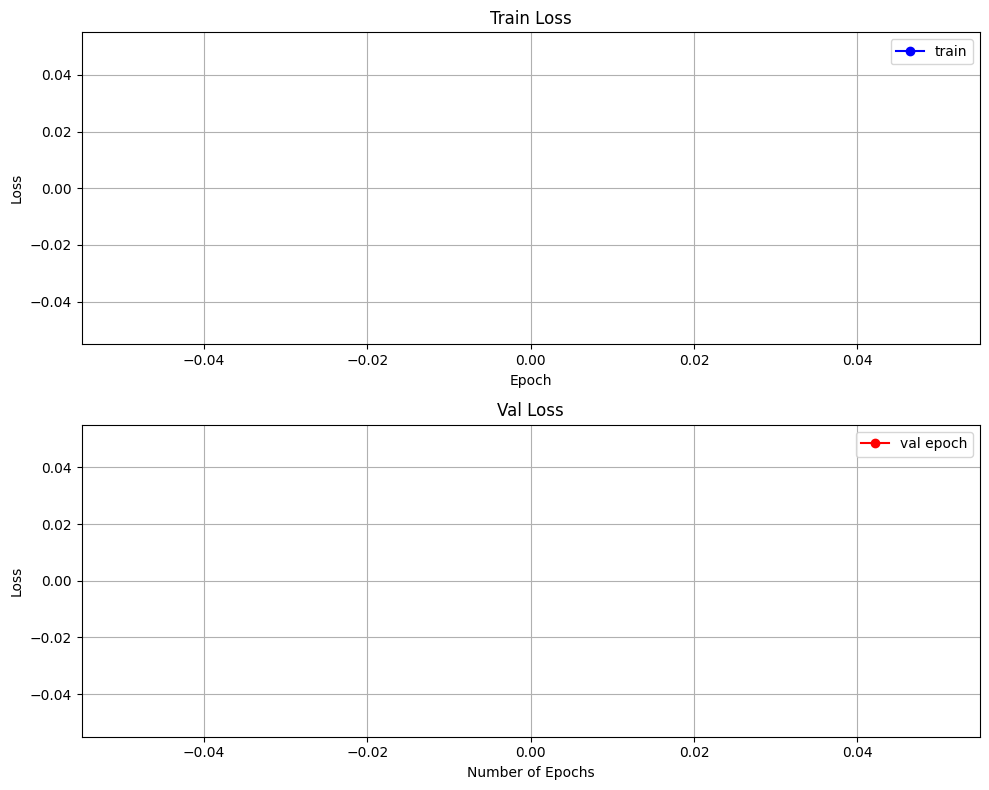

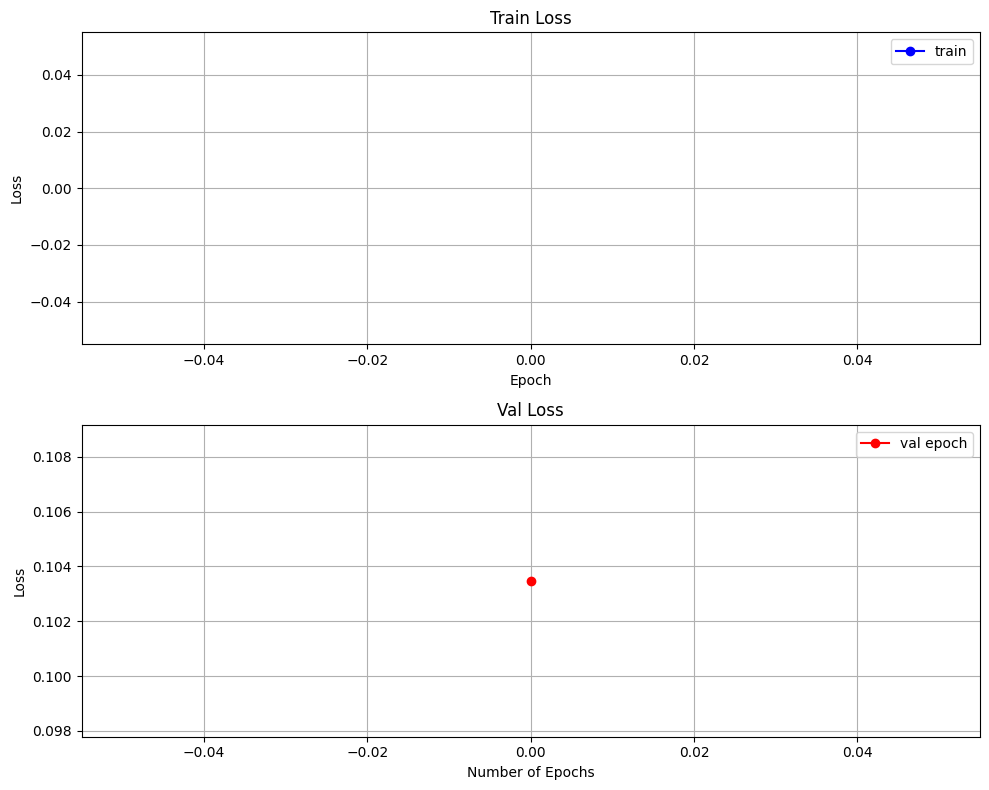

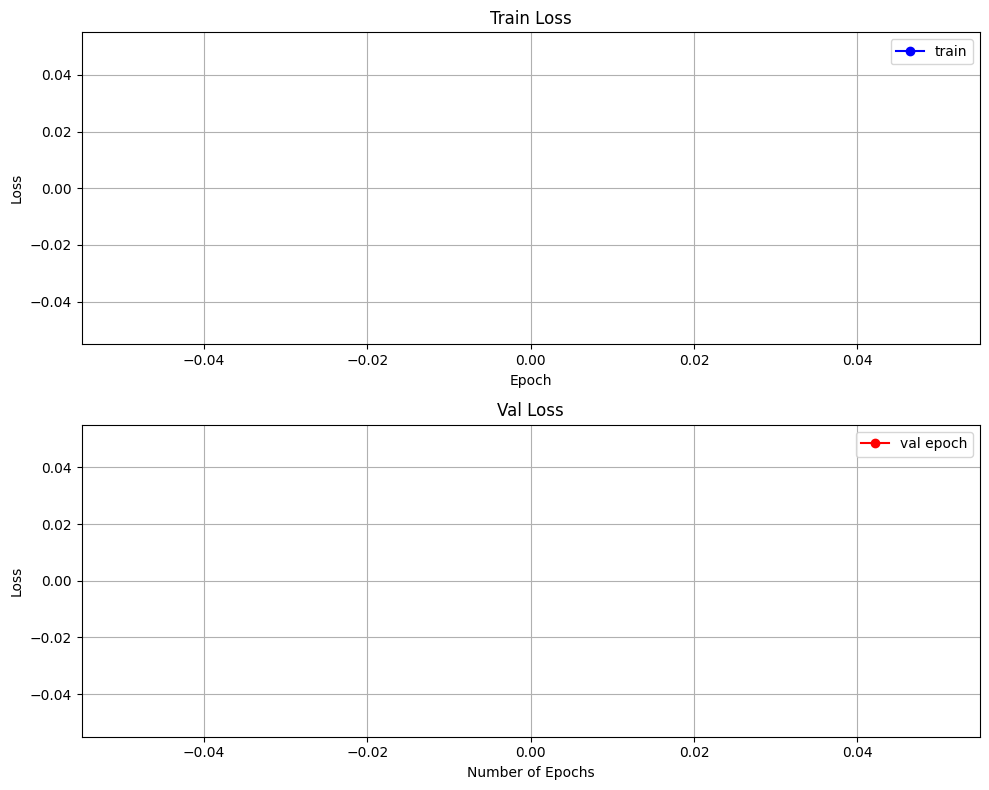

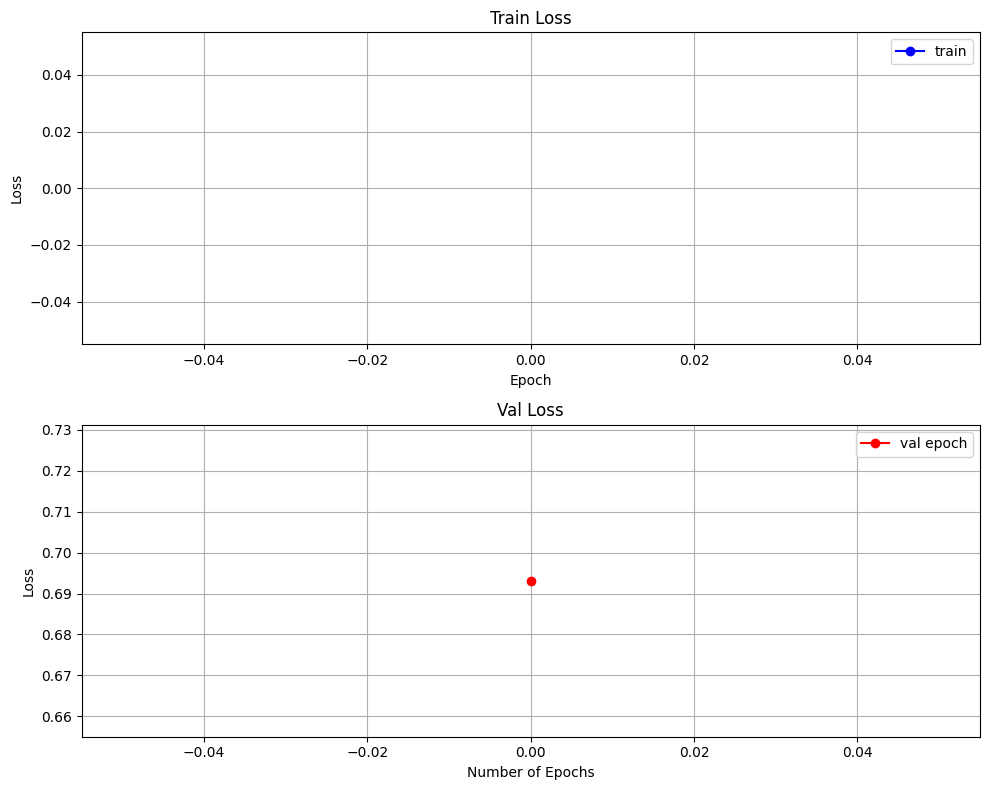

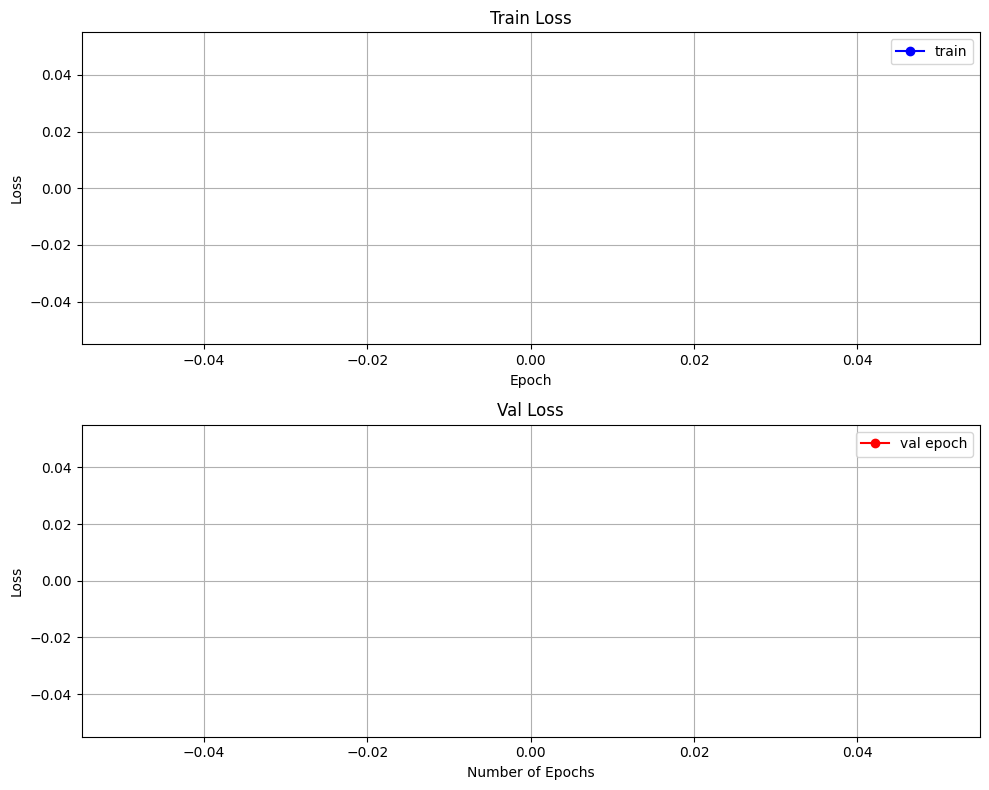

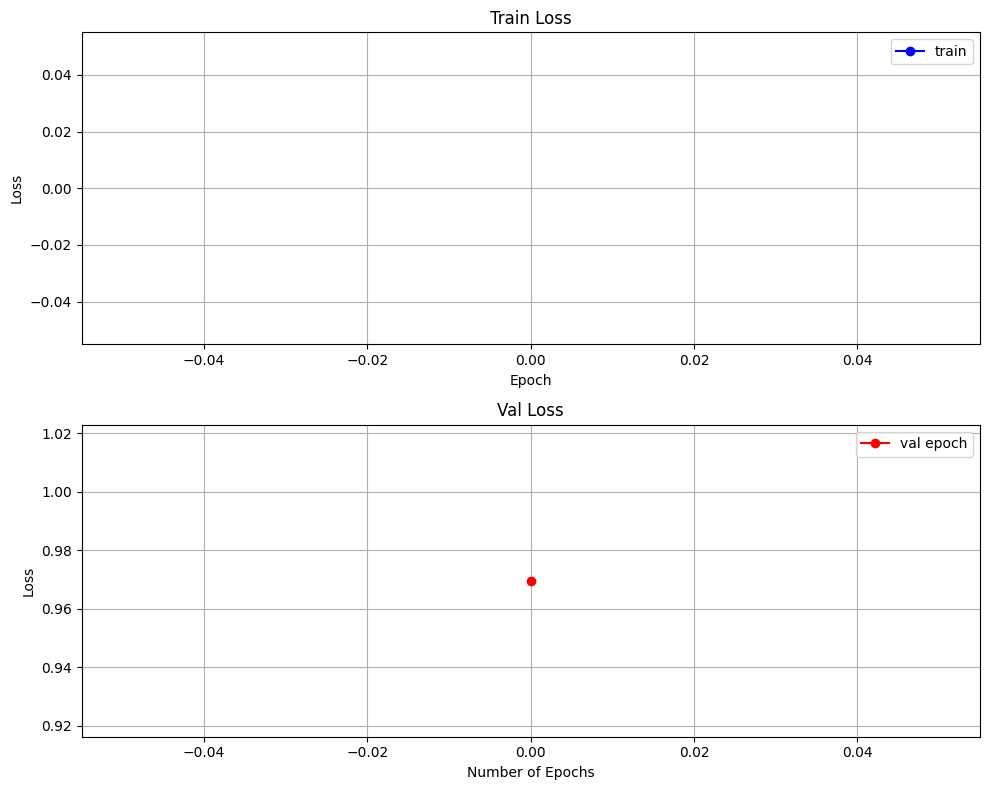

In [101]:
val_loss_no_pre = evaluate_n_train_iterations(folder_results=folder_results_no_pretraining, 
                            use_pretraining=False, 
                            n=10,
                            epochs=1)

In [102]:
import matplotlib.pyplot as plt

(array([1., 3., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1.]),
 array([0.10291097, 0.15031   , 0.19770904, 0.24510808, 0.29250711,
        0.33990615, 0.38730519, 0.43470423, 0.48210326, 0.5295023 ,
        0.57690134, 0.62430037, 0.67169941, 0.71909845, 0.76649748,
        0.81389652, 0.86129556, 0.9086946 , 0.95609363, 1.00349267,
        1.05089171, 1.09829074, 1.14568978, 1.19308882, 1.24048786,
        1.28788689, 1.33528593, 1.38268497, 1.430084  , 1.47748304,
        1.52488208]),
 <BarContainer object of 30 artists>)

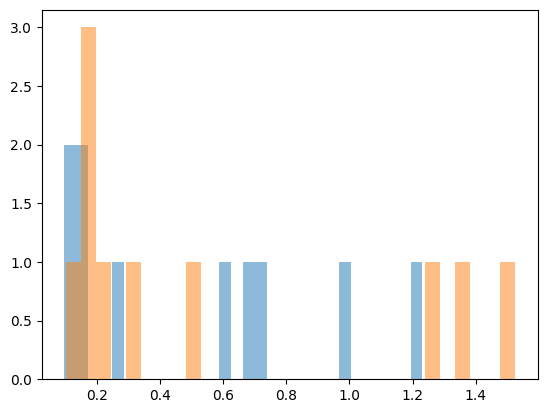

In [103]:
plt.hist(val_loss_no_pre, alpha=0.5, bins=30)
plt.hist(val_loss_pre, alpha=0.5,bins=30)

In [104]:
np.mean(val_loss_no_pre)

0.497875190526247

In [105]:
np.mean(val_loss_pre)

0.5762314960360527